# Part 1. Solving the unconstrained optimization problem

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). 

As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

## Preparation

In [136]:
FIGURE_SIZE = (20, 12)
dataset = "mushrooms.txt" 
#the file must be in the same directory as notebook.

In [137]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [138]:
y = 2 * y - 3

Let us divide the data into two parts: train and test.

In [139]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
X_train.shape

(6499, 112)

For $X_{train}$, $y_{train}$, estimate the constant $L$. 
Set $\lambda$ such that $\lambda \approx L / 1000$.  
Realize in the code the calculation of the value and gradient of $f$ ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them).

In [141]:
# let's seed the sources of randomness
import random
import numpy as np
random.seed(69)
np.random.seed(69)

from numpy.linalg import norm
from typing import Tuple, List, Union, Sequence
from tqdm import tqdm

In [142]:
# let's write a function to verify the input (shapes and other conditions...)
def p1_verify_input(X: np.ndarray, 
                    y: np.ndarray, 
                    w: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # first let's make sure the input is as expected: X is expected to have samples as rows
    if X.ndim != 2:
        raise ValueError(f"the training is expected to have at least 2 samples")
    
    num_samples, dim = X.shape 
    # make sure 'y' matches the number of samples
    y = np.expand_dims(y, axis=1) if y.ndim == 1 else y

    if y.shape != (num_samples, 1):
        raise ValueError((f"The number of labels is expected to match the number of samples"
                          f"\nFound: {y.shape} Expected: {(num_samples, 1)}"))

    w = np.squeeze(w)    
    # check 'w' as well:
    w = np.expand_dims(w, axis=-1) if w.ndim == 1 else w

    # make sure the dimensions match
    if w.shape != (dim, 1):
        raise ValueError((f"The weight matrix 'w' is expected as a column vector with length {dim}\n"
                          f"Expected: {(dim, 1)}. Found: {w.shape}"))
    return X, y, w

In [143]:
# all these functions were used in the previous assignment and have been heavily tested.
def p1_value_function(X: np.ndarray, 
                   y: np.ndarray,
                   w: np.ndarray, 
                   lam: float) -> float:
    """ This function calculates different values of the function gives it parameters:
    Args:
        X (np.ndarray): The training data
        y (np.ndarray): The labels
        w (np.ndarray): the weights
        lam (float): lambda: the regularization hyper-parameter

    Returns:
        float: The value for the function with parameter 'w'
    """
    # first step is to verify the input
    X, y, w = p1_verify_input(X, y, w)
    # now as our input has been verified we proceed by defining some useful intermediate variables
    A = X * y
    return np.mean(np.log(1 + np.exp((- A @ w).astype(np.float64)))) + (lam / 2) * np.linalg.norm(w) ** 2 

def p1_gradient_function(X: np.ndarray, 
                      y: np.ndarray, 
                      w: np.ndarray, 
                      lam: float) -> np.ndarray:
    # verify the input
    X, y, w = p1_verify_input(X, y, w)

    A = X * y
    preds = A @ w 

    # then calculate the mean over axis=0 to get a row vector    
    dl1 = np.mean(A / (1 + np.exp(preds)), axis=0)
    assert dl1.shape == (X.shape[1], )
    dl = - np.expand_dims(dl1, axis=-1) + lam * w
    assert dl.shape == (X.shape[1], 1), "The gradient is expected to be a column vector."
    return dl

In [144]:
def p1_L_estimation(X: np.ndarray,
                    y: np.ndarray,
                    w: np.ndarray) -> float:
    # return the estimation by the problem description
    X, y, w = p1_verify_input(X, y, w) 
    num_samples, _ = X.shape
    # first calculate L (without lambda)
    L = np.linalg.norm(X) ** 2 / (4 * num_samples)
    # set lambda
    lam = L / 1000
    return L + lam, lam

## Problem 0. (5 points)__  Implement the ability to uniformly divide the training part of the dataset into batches of size $b$ ($b$ is a parameter).

In [145]:
def split_into_batches(X: np.ndarray,
                       batch_size: int, 
                       y: np.ndarray=None,
                       even_split: bool = True
                       ) -> Union[Tuple[Sequence[np.ndarray], Sequence[np.ndarray]], Sequence[np.ndarray]]:
    """A function to split the data into batches. I discard shuffling in this function to make sure 
    the output is deterministic for the same 'X'

    Args:
        X (np.ndarray): The data samples
        batch_size (int): 
        y (np.ndarray, optional): labels. Defaults to None.
        even_split (bool, optional): Whether to have all batches split evenly. Defaults to True.

    Returns:
        Union[Tuple[Sequence[np.ndarray], Sequence[np.ndarray]], Sequence[np.ndarray]]: the data batches, [Optional] the label batches 
    """    
    # convert the batch size to 'int'
    batch_size = int(batch_size)
    
    # make sure to raise an error if the number of samples cannot be split into even batches (in case of 'even_split' is True)
    if even_split and len(X) % batch_size != 0:
        raise ValueError((f"Please pass a batch size that can split the data evenly or set 'even_split' to False.\n" 
                         f"The number of samples: {len(data)}. The batch size: {batch_size}"))
    
    if y is not None: 
        # make sure the number of samples is the same as that of the number of labels
        if len(X) != len(y):
            raise ValueError(f"The number of samples should be the same as the number of labels.")

        y = np.expand_dims(y, axis=-1) if y.ndim == 1 else y        

    if y is not None:
        return [X[i: i + batch_size] for i in range(0, len(X), batch_size)], [y[i: i + batch_size] for i in range(0, len(y), batch_size)]

    return [X[i: i + batch_size] for i in range(0, len(X), batch_size)]


## Problem 1. (50 points)__ This part of the assignment is related to __non-distributed stochastic__ methods.

### a). (5 points)__ Implement the SGD method:
$$
w^{k+1} = w^k - \gamma_k \nabla f_{j_k} (w^k),
$$
where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$.

Just in case, we give here a variant of the function description for the gradient descent from the first assignment. You can use this format if you wish. Note that ``x_sol`` occurs in the code - this problem should be solved or criteria tied to ``x_sol`` should not be used.

In [146]:
def x_difference(x1: np.ndarray, x2: np.ndarray) -> float:
    """Computes the euclidean norm of the difference vector 

    Args:
        x1 (np.ndarray): first vector
        x2 (np.ndarray): second vector

    Returns:
        float: returns the norm of the difference
    """
    return norm(x1 - x2, ord=2)

def f_difference(f1: float, f2: float) -> float:
    """returns the absolute difference between 2 values """
    # the expression f_x_k - f_sol is equivalent since the problem is minimization,
    # but the 'abs' function was used to make the method general and not only specific to the given problem
    return abs(f1 - f2)      

# let's define the modes in terms of strings
x_diff = 'x_k+1 - x_k'
f_diff = 'f(x_k+1) - f(x_k)'
normalized_criterion = 'df_xk / df_x0'
x_opt_diff = 'x* - x_k'

In [147]:
def stoachastic_gradient_descent(
                    data: np.ndarray, 
                    labels: np.ndarray,
                    data_batches: Sequence[np.ndarray],
                    label_batches: Sequence[np.ndarray],
                    function: callable,
                    grad_function: callable, 
                    x_0: np.ndarray,                      
                    x_sol: np.ndarray=None,
                    K: int = 10 ** 3,
                    eps: float = 10 ** -5, 
                    mode: str = normalized_criterion,
                    gamma_k: callable = None,                      
                    return_history: bool = False
                            ) -> Union[List[np.ndarray], np.ndarray]:
    """This function is an implementation of the Stochastic Gradient Descent algorithm.

    Args:
        data (np.ndarray): The entire training dataset
        labels (np.ndarray): The entire training labels
        data_batches (Sequence[np.ndarray]): A sequence of batches 
        label_batches (Sequence[np.ndarray]): A sequence of labels for the corresponding data labels
        function (callable): the loss function 
        grad_function (callable): The gradient function: should expect 'x', 'y' and 'w': data, labels and the weights
        x_0 (np.ndarray): the initial weights
        x_sol (np.ndarray, optional): The solution to the minimization function. Defaults to None.
        K (int, optional): Maximum number of iterations. Defaults to 10**3.
        eps (float, optional): The iterative process stops if the criterion is less that this value. Defaults to 10**-5.
        mode (str, optional): The criterion to compute for each weight. Defaults to normalized_criterion.
        gamma_k (callable, optional): a function that determines the step size at the k-th stepp. Defaults to None.
        return_history (bool, optional): whether to return the history of weights and criterions. Defaults to False.

    Returns:
        Union[List[np.ndarray], np.ndarray]: either the history of 'weights' and 'criterions' or the last weight
    """
    
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")
    
    x_current, x_previous = x_0, x_0
    x_history = [x_current]
    criterion_history = []

    for k in tqdm(range(K)):
        # sample the batch index: random batch
        data_index = random.randint(0, len(data_batches) - 1)
        # save the k-th point
        x_previous = x_current
        # calculate the current step size
        gamma = gamma_k(k)
        
        # create the arguments to pass to the gradient (only using the randomly selected batch)
        grad_args = {"X": data_batches[data_index], "y": label_batches[data_index], 'w': x_current}
        
        # create the arguments to pass to the function: the entire data
        func_args = {"X": data, 'y': labels, 'w': x_current}
        
        # compute the (k+1)-th point    
        x_current = x_current - gamma * grad_function(**grad_args)  

        if mode == f_diff:
            diff = f_difference(function(func_args), function(func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args), ord=2) / norm(grad_function(**{"X": data, 'y': labels, 'w': x_0}), ord=2)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
        
        if diff <= eps: 
            break

    assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    # the function will return all intermediate points if the 'return_history' argument is set to True
    # and only the last point otherwise    
    return (x_history, criterion_history) if return_history else x_history[-1]


### b). (7 points)__ 

Solve the optimization problem on the training sample using the implemented method. 

Take $b = 10$, and the step is $\gamma_k \equiv \frac{1}{\tilde L}$. 

From the point of view of the theory, what should be taken as $\tilde L$? 

Draw the convergence plot: the value of the convergence criterion ($\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number. 

Make a conclusion.

In [148]:
import matplotlib.pyplot as plt
# create the set up: x_0 and seed
def set_up(seed: int = 69) -> np.ndarray:
        # changing the seed mainly changes the starting point
    random.seed(seed)
    np.random.seed(seed)
    w_0 = np.random.randn(X_train.shape[1], 1)
    return w_0

In [149]:
# first let's split the data into batches to define the inner functions
X_BATCHES, Y_BATCHES = split_into_batches(X=X_train, y=y_train, batch_size=10, even_split=False)

def set_L_Reg(data, labels, data_batches, label_batches) -> Tuple[float, float]:
    L_tiled = float('inf')
    Reg_tiled = float('inf')

    for x, y in zip(data_batches, label_batches):
        # compute L_i, and mu_i
        l, r = p1_L_estimation(X=x, y=y, w=np.random.rand(x.shape[1], 1))        
        L_tiled = max(L_tiled, l)
        Reg_tiled = min(Reg_tiled, r)
    
    # make sure to compare L_i with the global L and mu_i with the global mu
    L, REG = p1_L_estimation(X=data, y=labels, w=np.random.rand(X_train.shape[1], 1))
    L_tiled, Reg_tiled = min([(L, REG), (L_tiled, Reg_tiled)], key=lambda x: x[0])
    return L_tiled, Reg_tiled

L_TILED, REG_TILED = set_L_Reg(X_train, y_train, X_BATCHES, Y_BATCHES)

from functools import partial
# a callable object with the main loss, gradient and hessian
p1_stochastic_value = partial(p1_value_function, lam=REG_TILED)
p1_stochastic_grad = partial(p1_gradient_function, lam=REG_TILED)

# the estimation of 'L'
assert abs(L_TILED / REG_TILED - 1000) <= 10

In [150]:
def simulation( data: np.ndarray, 
                labels: np.ndarray,
                data_batches: Sequence[np.ndarray],
                label_batches: Sequence[np.ndarray],
                optimization_algorithm: callable,
                function: callable, 
                grad_function: callable, 
                gamma_k: callable=None,
                momentum_k: callable=None,  
                K = 10**3, 
                eps = 10**-8, 
                mode = normalized_criterion, 
                seed: int = 69, 
                x_sol: np.ndarray=None
               ):
    
    # this call ensures that all simulations star with the same 'x_0'
    x_0 = set_up(seed=seed)
    
    # get the points from the gradient descent
    if momentum_k is not None:
        x_points, criterions = optimization_algorithm(
                                    data=data,
                                    labels=labels, 
                                    data_batches=data_batches, 
                                    label_batches=label_batches,
                                    function=function, 
                                    grad_function=grad_function,  
                                    x_0=x_0,
                                    gamma_k=gamma_k,
                                    momentum_k=momentum_k,
                                    K = K,
                                    eps=eps,
                                    mode=mode, 
                                    return_history=True, 
                                    x_sol=x_sol
                                    )
        return x_points, criterions

    x_points, criterions = optimization_algorithm(
                                data=data,
                                labels=labels,
                                data_batches=data_batches,
                                label_batches=label_batches,
                                function=function, 
                                grad_function=grad_function,  
                                x_0=x_0,
                                gamma_k=gamma_k,
                                K = K,
                                eps=eps,
                                mode=mode, 
                                return_history=True,
                                x_sol=x_sol 
                                )

    return x_points, criterions   

In [151]:
def plot_iterations(criterions: List[float],
                    start_index: int = 0, 
                    end_index: int = -1,
                    xs: np.ndarray = None,
                    plot_label: str = None,
                    x_label: str = None,
                    y_label: str = None,
                    show:bool = True,
                    ):
    
    end_index = (end_index + len(criterions)) % len(criterions)

    if xs is None:
        xs = list(range(len(criterions)))

    if plot_label is None:
        plt.plot(xs[start_index: end_index], criterions[start_index:end_index])
    else:
        plt.plot(xs[start_index: end_index], criterions[start_index:end_index], label=str(plot_label))
    

    plt.xlabel('iteration' if x_label is None else x_label)
    plt.ylabel('criterion (log_{10} scale)' if x_label is None else y_label)
    
    if show:
        plt.legend()
        plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 195.06it/s]


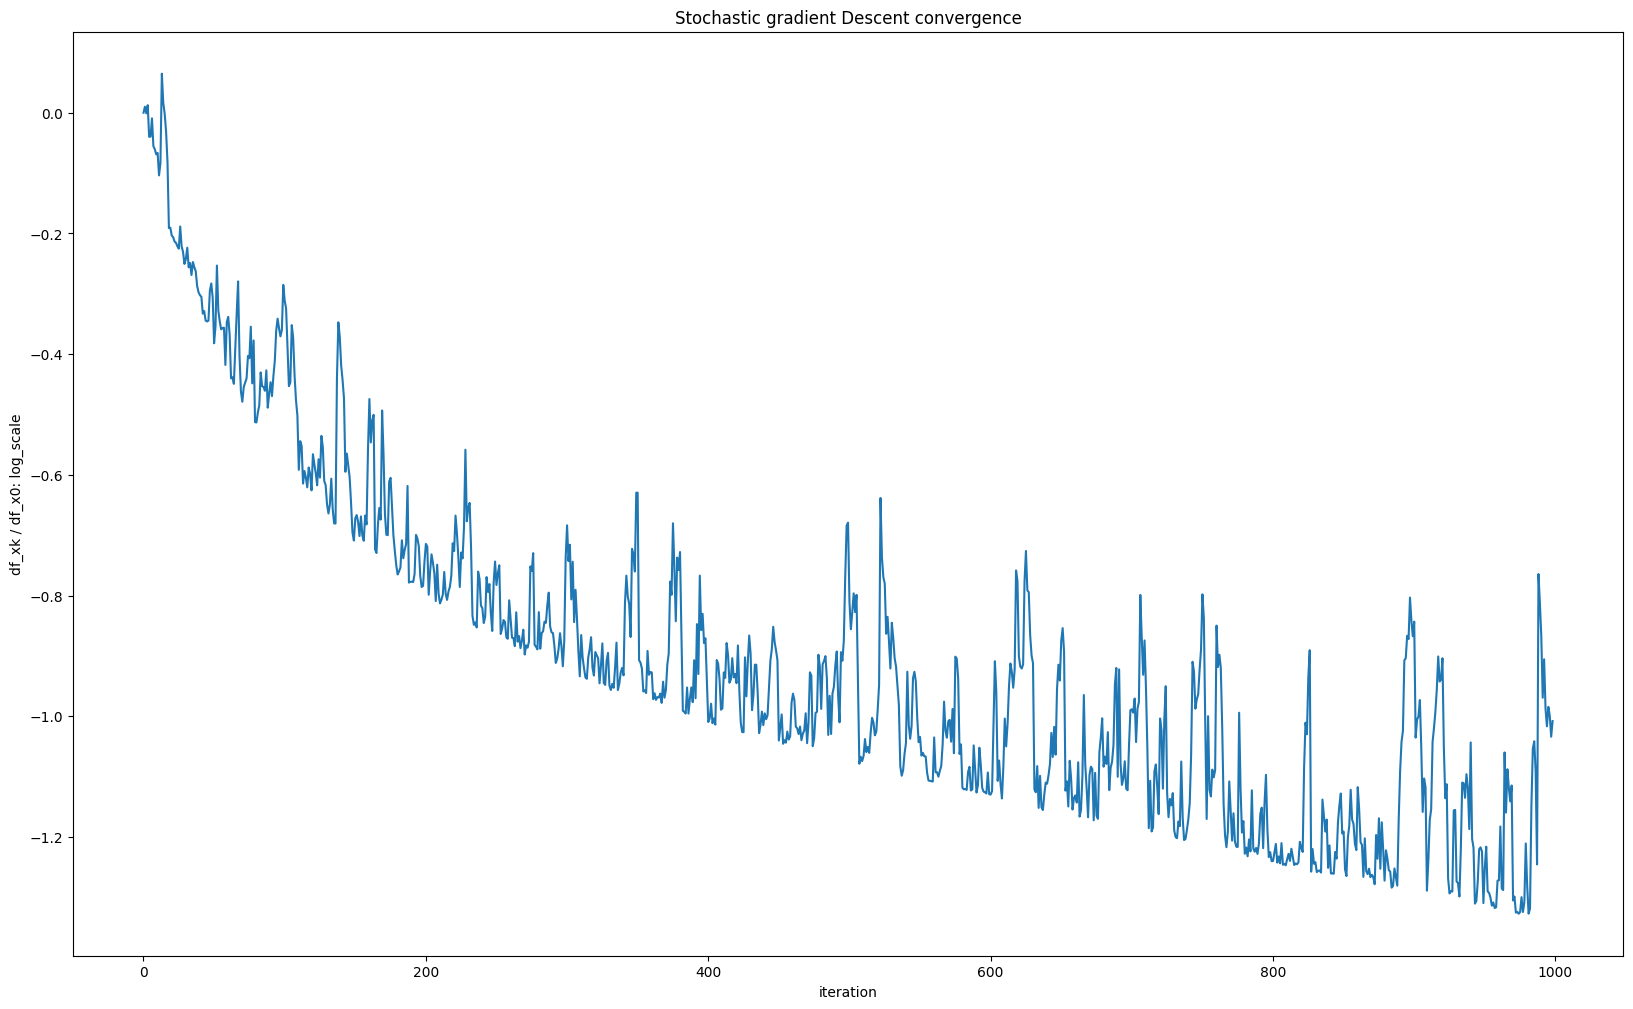

In [152]:
constant_gamma_k = lambda _ : 1 / L_TILED

plt.figure(figsize=FIGURE_SIZE)

# run the simulation 
x_points, criterions = simulation(data=X_train, 
                                  labels=y_train,
                                  data_batches=X_BATCHES,
                                  label_batches=Y_BATCHES, 
                                optimization_algorithm=stoachastic_gradient_descent, 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=constant_gamma_k, 
                                mode=normalized_criterion)

criterions = [np.log10(c) for c in criterions]

plot_iterations(criterions=criterions, 
                x_label='iteration', 
                y_label=f'{normalized_criterion}: log_scale', 
                show=False)

plt.title("Stochastic gradient Descent convergence")
plt.show()      

#### b: Theoretical L
We know the following: 

1. the function $f$ and $f_i$ must have the same smooth constant $L$ and the same strong convexity constant $\mu$
2. if a function $f$ is $L_1$ smooth and $L_1 > L_2$, then f is also $L_2$ smooth
3. If $f$ is $\mu_1$ strongly convex and $\mu_2 < \mu_1$ then $f$ is also $\mu_2$ strongly convex 
4. We are setting $\mu = \frac{L}{1000}$ 

Given these observations, we choose 

$$ 
\tilde{\mu} = \min(\mu_1, \mu_2, ... \mu_s) \\
\tilde{L}  = \max(L, L_1, L_2, ... L_s)
$$

#### b: Conclusion
1. We can see that the practical results match the theoretical estimations: convergence with linear rate to the neighborhood of the solution.
2. The batch is relatively small: $b$ which explains the variance in the criterion. A larger batch is expected to make the convergence smoother 

### c). (7 points)__ 
Vary the batch size: $b = 1, 10, 100, 1000$, 

take the step size equal to $\gamma_k \equiv \frac{1}{\tilde L}$ (note that $\tilde L$ need to be recalculated for each $b$). 

Draw the convergence plot: the value of the convergence criterion from the iteration number for each $b$. 

Does this plot reflect a fair comparison? Why? 

Figure out how to compare the results to each other more honestly (running time is a good option, but you can't use it here) 

and draw a new comparison plot. 

Make a conclusion.

100%|██████████| 1000/1000 [00:04<00:00, 216.51it/s]


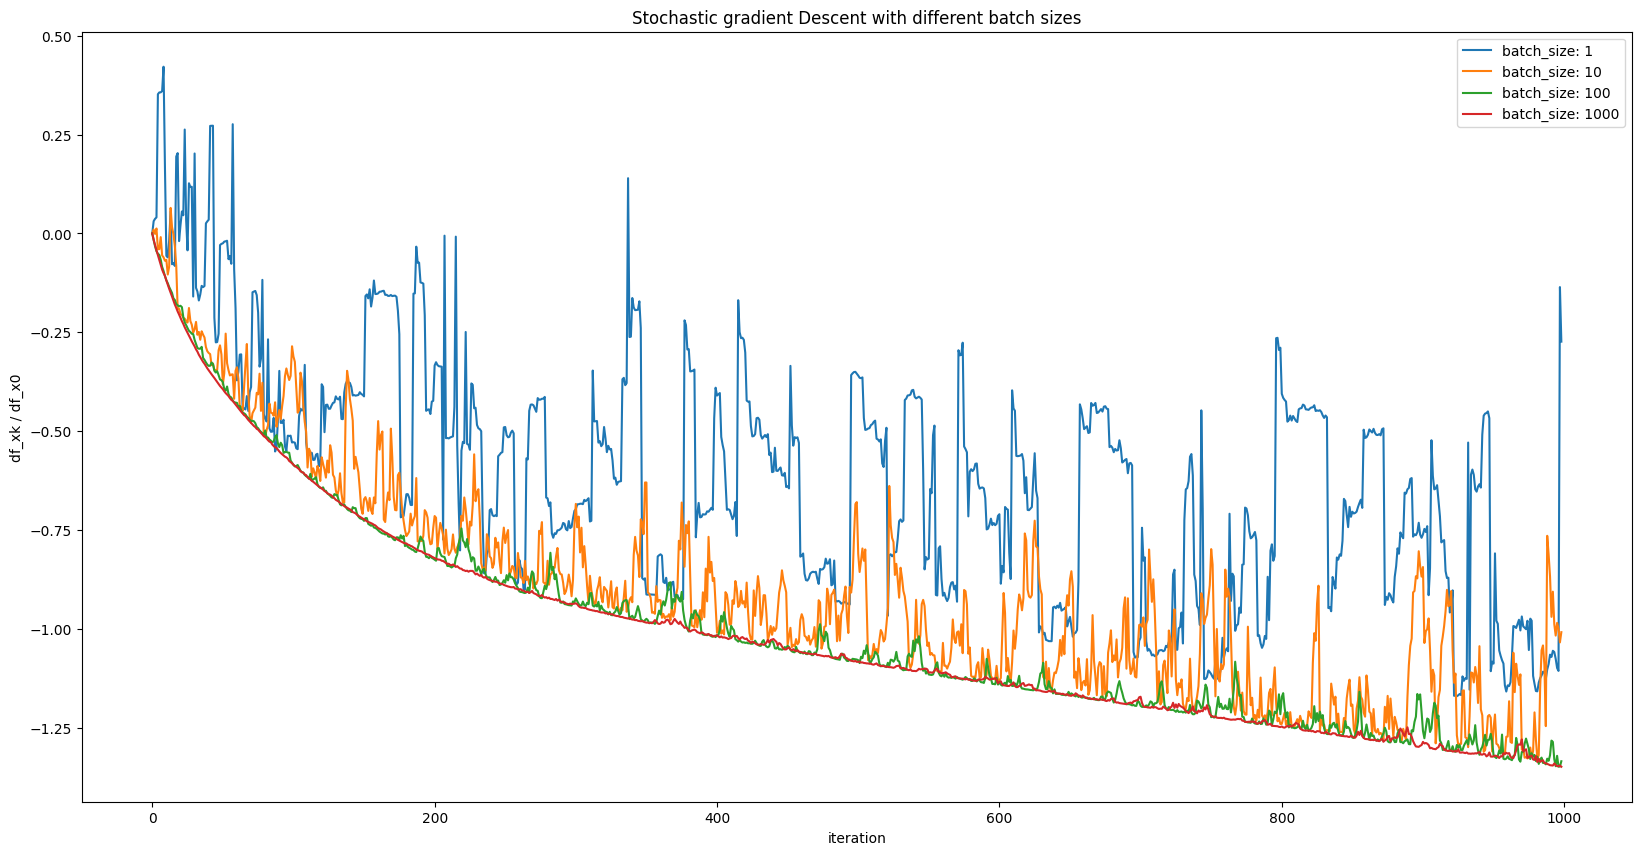

In [153]:
# let's vary the batch size:
plt.figure(figsize=(20, 10))
for b in [1, 10, 100, 1000]:
    # split the data
    data_batches, label_batches = split_into_batches(X=X_train, batch_size=b, y=y_train, even_split=False)
    
    # get the value 'L'
    l_tilde, reg_tilde = set_L_Reg(data=X_train, labels=y_train, data_batches=data_batches, label_batches=label_batches)
    
    constant_gamma_k = lambda _ : 1 / l_tilde

    # redefine the funtions
    
    sto_value = partial(p1_value_function, lam=reg_tilde)
    sto_grad = partial(p1_gradient_function, lam=reg_tilde)

    # run the simulation 
    x_points, criterions = simulation(data=X_train, 
                                    labels=y_train, 
                                    data_batches=data_batches,
                                    label_batches=label_batches, 
                                    optimization_algorithm=stoachastic_gradient_descent, 
                                    function=sto_value,
                                    grad_function=sto_grad,
                                    gamma_k=constant_gamma_k, 
                                    mode=normalized_criterion)

    criterions = [np.log10(c) for c in criterions]
    plot_iterations(criterions=criterions, 
                    x_label='iteration', 
                    y_label=f'{normalized_criterion}',
                    plot_label=f'batch_size: {b}', 
                    show=False)

plt.legend()
plt.title("Stochastic gradient Descent with different batch sizes")
plt.show()      


100%|██████████| 4/4 [00:00<00:00, 201.46it/s]


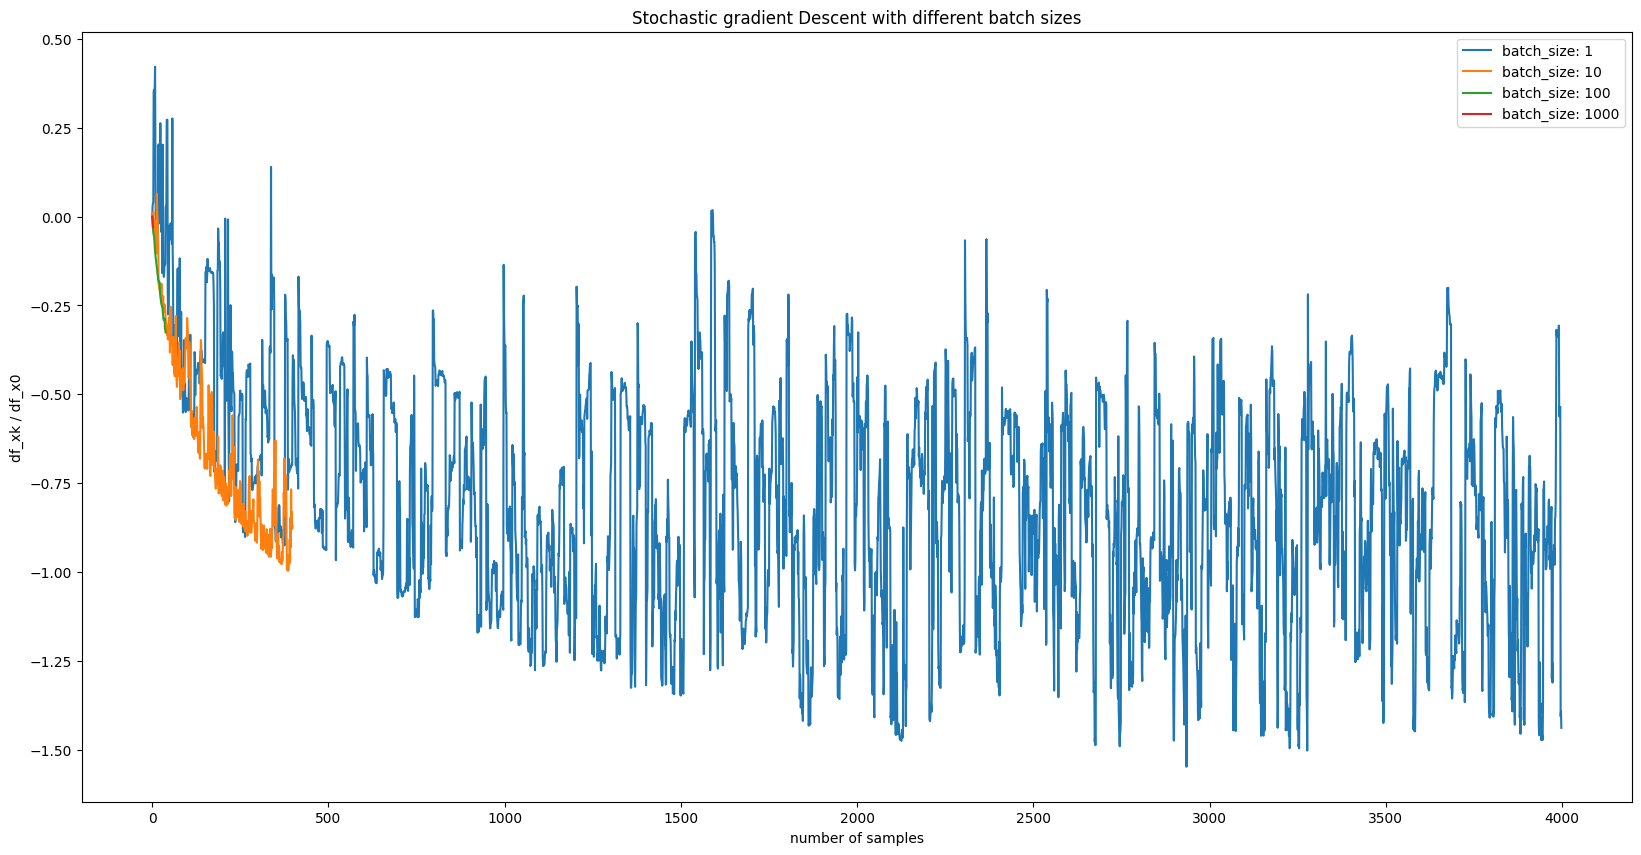

In [154]:
import math
# let's vary the batch size:
plt.figure(figsize=(20, 10))

for b in [1, 10, 100, 1000]:
    # split the data
    data_batches, label_batches = split_into_batches(X=X_train, batch_size=b, y=y_train, even_split=False)
    # get the value 'L'
    l_tilde, reg_tilde = set_L_Reg(data=X_train, labels=y_train, data_batches=data_batches, label_batches=label_batches)
    
    constant_gamma_k = lambda _ : 1 / l_tilde
    # redefine the funtions
    
    sto_value = partial(p1_value_function, lam=reg_tilde)
    sto_grad = partial(p1_gradient_function, lam=reg_tilde)

    # run the simulation 
    x_points, criterions = simulation(data=X_train, 
                                    labels=y_train, 
                                    data_batches=data_batches,
                                    label_batches=label_batches, 
                                    optimization_algorithm=stoachastic_gradient_descent, 
                                    function=sto_value,
                                    grad_function=sto_grad,
                                    gamma_k=constant_gamma_k, 
                                    mode=normalized_criterion, 
                                    K=int(math.ceil(4 * 10 ** 3 / len(data_batches[0])))  
                                    # make sure all runs calculate the gradient on the same total number of samples. 
                                    )

    criterions = [np.log10(c) for c in criterions]
    plot_iterations(criterions=criterions, 
                    x_label='number of samples', 
                    y_label=f'{normalized_criterion}',
                    plot_label=f'batch_size: {b}', 
                    show=False)

plt.legend()
plt.title("Stochastic gradient Descent with different batch sizes")
plt.show()      

#### c: Is it a fair Comparison ?
No it is not a fair comparison.  Stochastic gradient descent with batch size 1 computes the gradient over 1000 (number of iterations) samples overall, while The gradient descent with a batch size of 1000 computes the gradient using $1000 ^ 2 = 10^6$ samples (with repetition). It is only natural for the latter to have better / smoother convergence.

One possible fair criterion is to normalize the number of iterations by the size of the batch. So if SGD with batch size 1, runs for $10 ^ 4$ iterations, SGD with batch size 1000, should run for 10 iterations only. This way both runs use the same number of samples.

#### c: Conclusion
*  We can see that even though the gradient estimate of a 1000-sample batch is steeper and much more accurate than that with a 1-sample batch size. However, a batch size of 1000 will end up with very few iterations to actually converge.

* We can see here that larger batch sizes decrease the variance in of the gradient estimation. However, The most crucial factor is the total number of iterations.

### d). (6 points)__ Let us fix $b = 10$ and try to change the strategy of choosing the step:

1) $\gamma_k \equiv \frac{1}{\tilde L}$ as we did before,

2) $\gamma_k \equiv \text{const}$, selecting $\text{const}$ to get the "best" convergence (explain what you mean by "best"),

3) $\gamma_k = \frac{1}{\sqrt{k + 1}}$, 

4) $\gamma_k = \frac{1}{k + 1}$.

Draw the convergence plot: the value of the convergence criterion from the iteration number. 

Make a conclusion.

#### Choosing the 'best' step size: a theoretical idea

According to the convergence analysis of SGD, conducted in the 10th-lecture, SGD converges linearly (to the neighborhood of the solution) for any fixed step size: 

$$ 
R ^2_{k + 1} \leq (1 - \mu \cdot \gamma)^k \cdot R_0 ^ 2 + \frac{2 \gamma}{\mu} \cdot G ^ 2
$$

where $G^2 = \frac{1}{n} \sum_{i=1}^n{\|f_i(x^{*}) \| ^ 2}$ and $R^2_{k} = \mathbb{E}[ \| x^{k} - x ^{*} \| ^ 2]$

We can extend the inequality above for more flexibility: 

\begin{align}
R ^2_{k + 1} &\leq (1 - \mu \cdot \gamma)^k \cdot R_0 ^ 2 + \frac{2 \gamma}{\mu} \cdot G ^ 2 \\ 
R ^2_{k + 1} &\leq \max(R_0 ^ 2, G ^ 2) \cdot ((1 - \mu \cdot \gamma)^k  + \frac{2 \gamma}{\mu}) \\ 
\end{align}

Let's denote $h(\gamma) = (1 - \mu \cdot \gamma)^k  + \frac{2 \gamma}{\mu}$ and 
$\frac{dh}{d\gamma} = \frac{2}{\mu} - \mu \cdot (1 - \mu \cdot \gamma) ^ {k - 1}$. 

Since we know that $\gamma < \frac{1}{\mu}$ and $\mu < 1$, then we can see that $\frac{dh}{d\gamma} > 0$ since ($\mu \cdot (1 - \mu \gamma)^k < 1$) and Thus, $h(\gamma)$ is minimal for $\gamma = 0$ (in the interval $[0, \frac{1}{\mu}]$). However, we cannot use a step size of $0$.

Thus, we resort to a practical tradeoff. for $ \frac{1}{\mu} \geq \gamma > 0$ SGD will converge in linear time to a neighborhood of the solution. The larger, $\gamma$ is, the faster (Theoretically) the algorithm is guranteed to converge. However, The larger $\gamma$ is, the larger the final neighborhood will be.

Assuming we would like $$h_{K}(\gamma) \leq \epsilon$$ for given $K$ steps and error $\epsilon$, Then we can simply
find the smallest $\gamma$ satisfying such condition: 

\begin{align}
(1 - \mu \cdot \gamma) ^ K &\leq \epsilon \\
x ^ K &\leq \epsilon  && \text{denote $1 - \mu \cdot \gamma$ by $x$} \\
e^ {log(x) \cdot K} \leq \epsilon \\
log(x) \cdot K &\leq \log(\epsilon) \\
x &\leq e ^ {\frac{\log(\epsilon)}{K}} \\
\frac{1 - e ^ {\frac{\log(\epsilon)}{K}}}{\mu} &\leq \gamma
\end{align}

Thus for given maximum number of steps $K$ and error $\epsilon$, we can define the 'best' $\gamma$ as: 
$$ \gamma = \frac{1 - e ^ {\frac{\log(\epsilon)}{K}}}{\mu} $$

#### Choosing the 'best' step size: The practical approach
The only paper I found that analysis SGD with both smoothness + strong convexity + constant step size is the [following](https://arxiv.org/pdf/1308.6370.pdf): 

However, this work is based on a very strong assumption that is not satisfied in our case: "Strong Growth condition". 

Thus, it might not be possible to derive the 'best' theoretical step size using all the assumptions on our problem. Hence, I additionally use a practical approach where I perform grid search across a set of values $\alpha$ between $[0.5, 2]$ and set the step size to $\frac{\alpha}{L}$

In [155]:
# let's define the different gammas
def get_best_gamma(epsilon, K, mu):
    return (1 - np.exp(np.log(epsilon) / K)) / mu

EPSILON = 10 ** -10
K = 10 ** 5
BEST_GAMMA_SGD_THEORETICAL = get_best_gamma(EPSILON, K, REG_TILED)
BEST_GAMMA_SGD_THEORETICAL

0.043853714636850796

In [156]:
X_BATCHES, Y_BATCHES = split_into_batches(X=X_train, y=y_train, batch_size=10, even_split=False)

L_TILED, REG_TILED = set_L_Reg(X_train, y_train, X_BATCHES, Y_BATCHES)

from functools import partial
# a callable object with the main loss, gradient and hessian
p1_stochastic_value = partial(p1_value_function, lam=REG_TILED)
p1_stochastic_grad = partial(p1_gradient_function, lam=REG_TILED)

# the estimation of 'L'
assert abs(L_TILED / REG_TILED - 1000) <= 10

In [157]:
# let's find the practical best step size
min_criterion, best_alpha = float('inf'), None 
for alpha in np.linspace(0.5, 2, num=10):
    if alpha == 1:
        continue

    gamma_function_obj = lambda _ : alpha / L_TILED
    x_points, criterions = simulation(data=X_train, 
                                    labels=y_train,
                                    data_batches=X_BATCHES,
                                    label_batches=Y_BATCHES, 
                                    optimization_algorithm=stoachastic_gradient_descent, 
                                    function=p1_stochastic_value,
                                    grad_function=p1_stochastic_grad,
                                    gamma_k=gamma_function_obj, 
                                    mode=normalized_criterion,
                                    K=10 ** 3)
    if min(criterions) < min_criterion:
        min_criterion = min(criterions)
        best_alpha = alpha

BEST_GAMMA_SGD_PRACTICAL = best_alpha / L_TILED

100%|██████████| 1000/1000 [00:05<00:00, 167.72it/s]


In [158]:
print(f"BEST ALPHA: {best_alpha}")

BEST ALPHA: 2.0


100%|██████████| 1000/1000 [00:05<00:00, 190.80it/s]


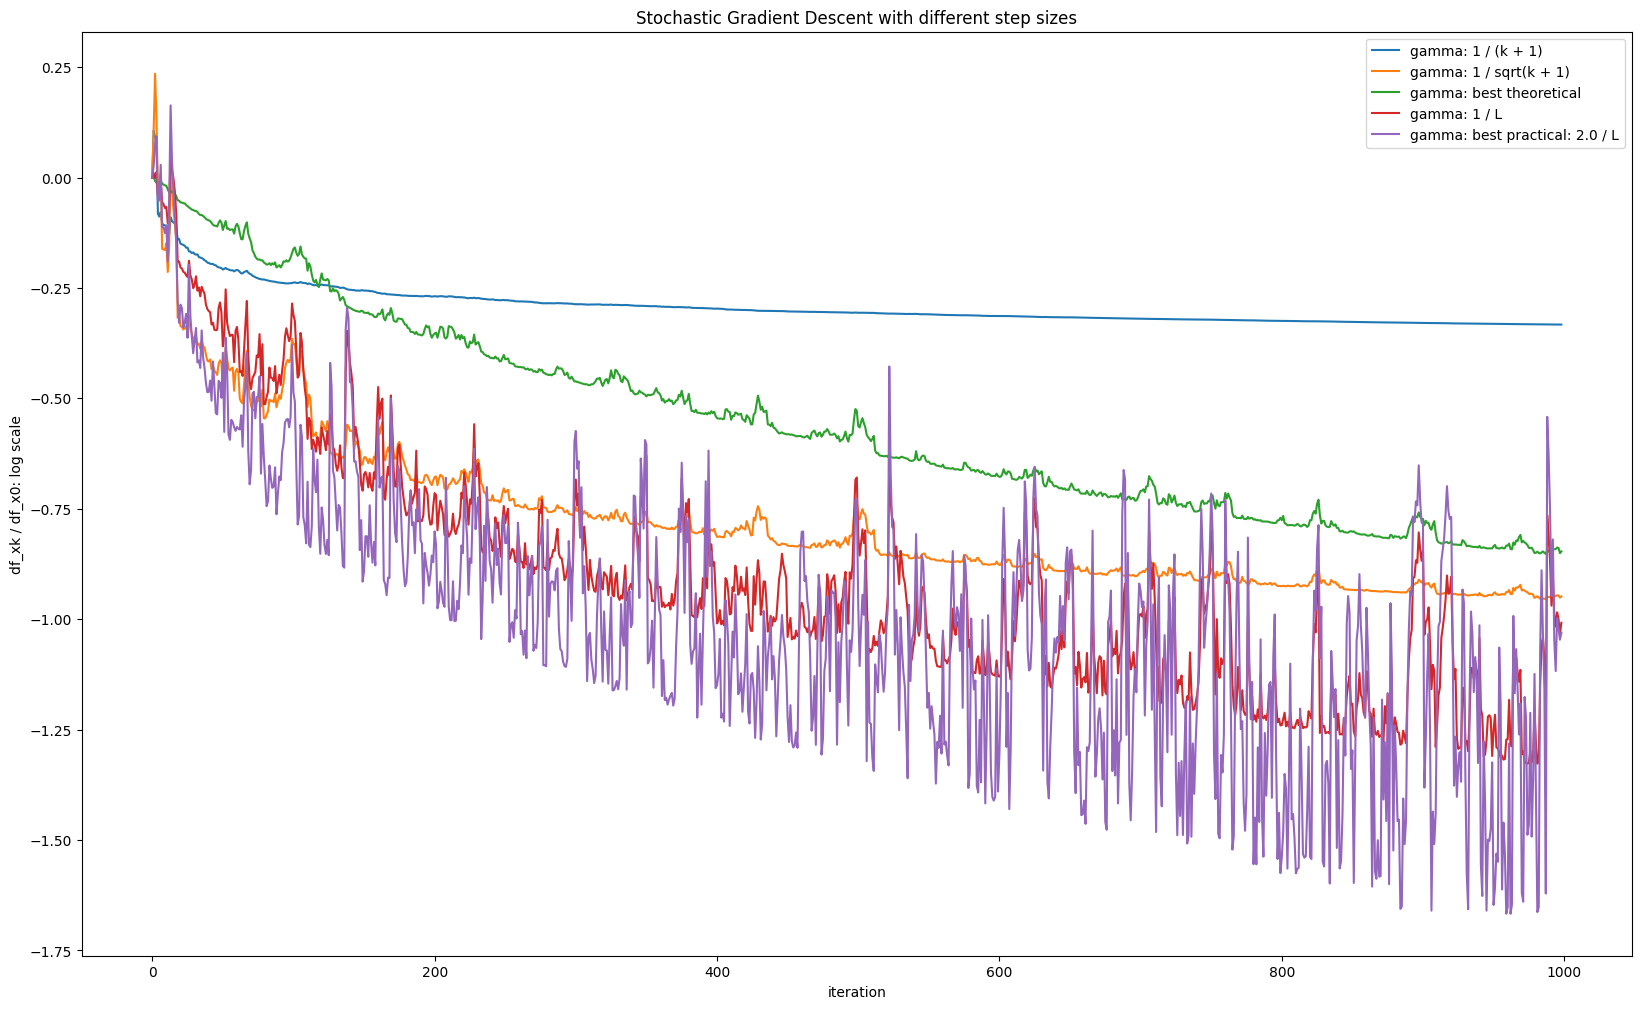

In [159]:
plt.figure(figsize=(20, 12))
gamma_inverse_k = lambda  k : 1 / (k + 1)
gamma_inverse_square_k = lambda  k :1 / np.sqrt(k + 1)
gamma_best_SGD_THEORETICAL = lambda _ : BEST_GAMMA_SGD_THEORETICAL
gamma_best_SGD_PRACTICAL = lambda _ : BEST_GAMMA_SGD_PRACTICAL
gamma_constant_L_TILED  = lambda _ : 1 / L_TILED

gamma_labels = ['1 / (k + 1)', '1 / sqrt(k + 1)', 'best theoretical', '1 / L', f'best practical: {round(best_alpha, 3)} / L']

for gamma_function_obj, gamma_label in zip([gamma_inverse_k, gamma_inverse_square_k, gamma_best_SGD_THEORETICAL, gamma_constant_L_TILED, gamma_best_SGD_PRACTICAL], gamma_labels):
    x_points, criterions = simulation(data=X_train, 
                                    labels=y_train,
                                    data_batches=X_BATCHES,
                                    label_batches=Y_BATCHES, 
                                    optimization_algorithm=stoachastic_gradient_descent, 
                                    function=p1_stochastic_value,
                                    grad_function=p1_stochastic_grad,
                                    gamma_k=gamma_function_obj, 
                                    mode=normalized_criterion,
                                    K=10 ** 3)

    criterions = [np.log10(c) for c in criterions]
    plot_iterations(criterions=criterions, 
                    x_label='iteration', 
                    y_label=f'{normalized_criterion}: log scale',
                    plot_label=f'gamma: {gamma_label}', 
                    show=False)    

plt.legend()
plt.title("Stochastic Gradient Descent with different step sizes")
plt.show()

#### Conclusion 
We can see that the step size $\gamma = \frac{2}{L}$  and $\gamma = \frac{1}{L}$ reach the best performances. Such results can be explained by the importance of smoothness in the algorithm's convergence.  

Theoretically SGD can only converge to a neighborhood of the solution with a constant step size. However, in practice, it seems that step sizes $\frac{1}{k + 1}, \frac{1}{\sqrt{k+1}}$, might reach very low values that make it difficult for SGD to converge to the solution fast enough.

### e). (5 points)__ 

In the previous hometask, we used the obtained solution of the optimization problem to predict answers on a test sample. 

Recall the essence: the original regression problem is a machine learning problem and using a linear model $g$ we can predict the values of labels $y$. 

Suppose we have a sample $x_i$, the model response for this sample is $g(w^*, x^i)$. 

Then the predictive rule can be formulated in the following rather natural way:
$$
y_i = 
\begin{cases}
1, & g(w^*, x^i) \geq 0,
\\
-1, & g(w^*, x^i) < 0.
\end{cases}
$$
By making predictions on the test sample $X_{test}$, we can compare the result with the real labels $y_{test}$. The number of correctly guessed labels is the accuracy of the model.

Look at the accuracy of the model trained with SGD. 

Repeat point c)-d), but now plot the accuracy dependence, not the convergence criterion. 

Make a conclusion.

In [160]:
def predict(w: np.ndarray, X: np.ndarray) -> np.ndarray:
    # make sure 'w' is a column vector
    if w.ndim > 2: 
        raise ValueError(f"Make sure that 'w' represents weights !!. Found: {w.shape}")
    
    w = np.expand_dims(w, axis=-1) if w.ndim == 1 else w
    
    res = ((X @ w) >= 0).squeeze()

    return 2 * res - 1

def calculate_accuracy(predictions: np.ndarray, labels: np.ndarray) -> float:
    ps = predictions.squeeze()
    ls = labels.squeeze()
    if ps.shape != ls.shape:
        raise ValueError(f"The predictions and the labels must have the same shape. Found: predictions: {ps.shape}. Labels: {ls.shape}")
    
    return np.mean(ps == ls).item()

# def bar_plot(x: Sequence, 
#              y: Sequence, 
#              x_label: str, 
#              y_label: str, 
#              title: str,
#              fig_size: Tuple[int, int], 
#              ax = None, 
#              show:bool =True,
#              xticks=None) -> None:
#     plt.figure(figsize = fig_size)

#     plt.bar(x, y, color ='maroon', width = 0.4)

#     if xticks is not None:
#         plt.xticks(ticks=xticks, rotation=90)
#     else:
#         plt.xticks(rotation=90)
    
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.title(title)

#     if show: 
#         plt.show()


### Point c: with accuracy

100%|██████████| 1000/1000 [00:07<00:00, 130.78it/s]


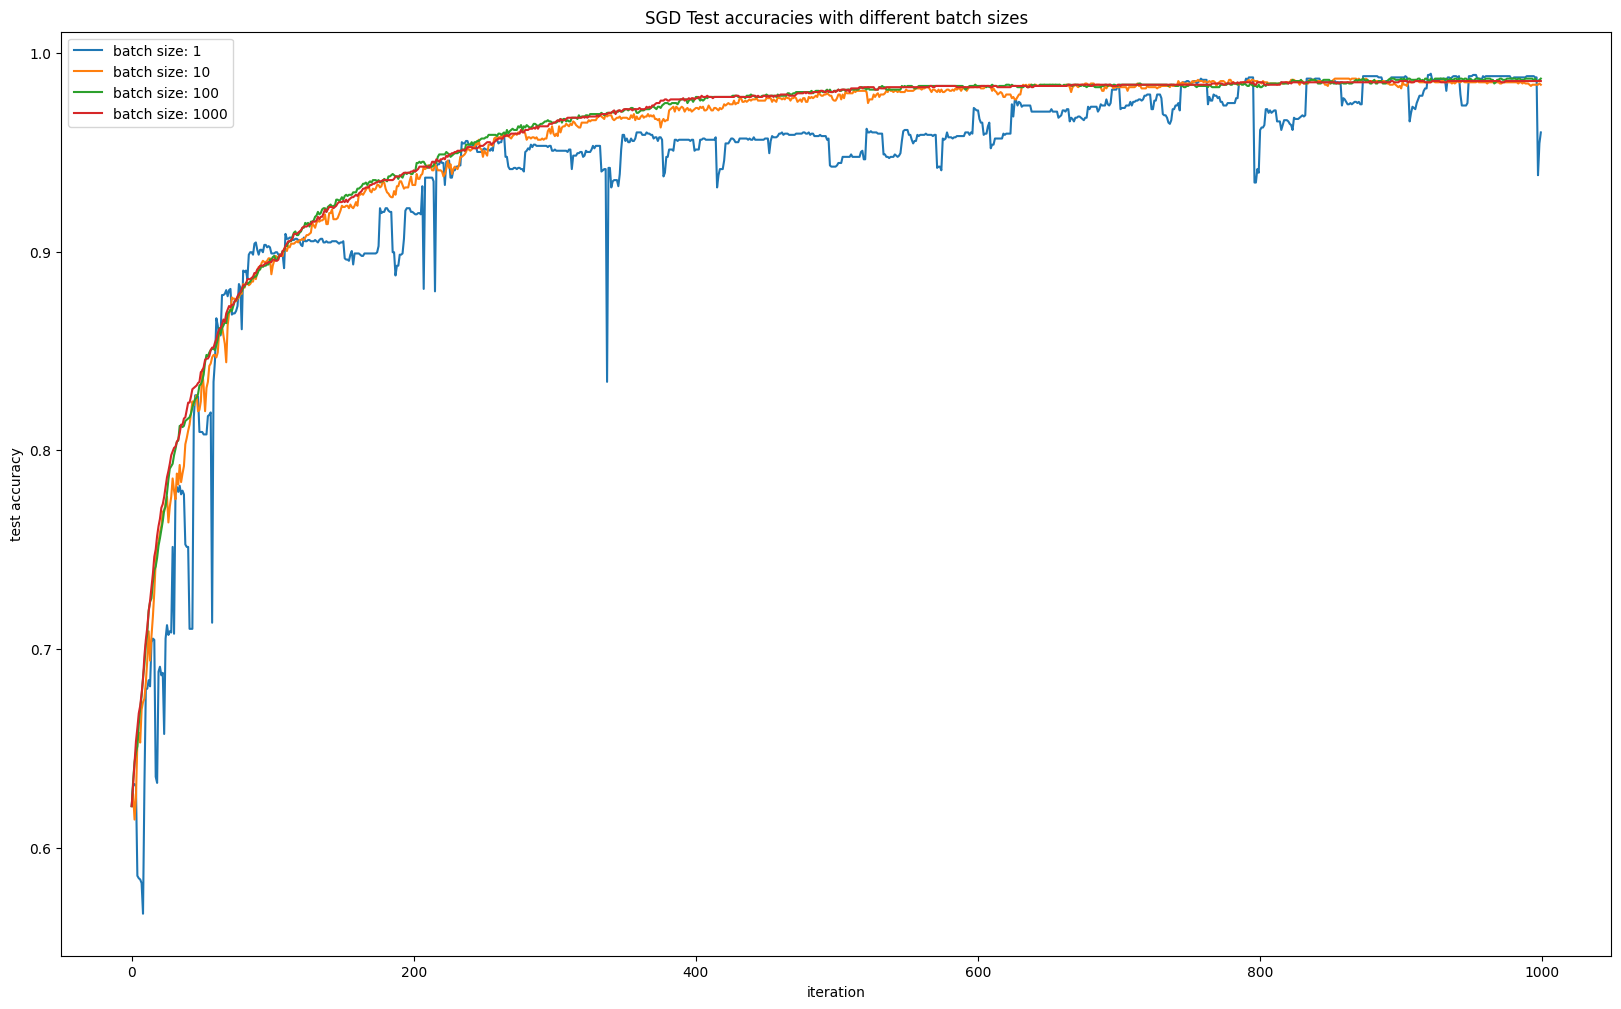

In [161]:
plt.figure(figsize=FIGURE_SIZE)
batch_sizes = [1, 10, 100, 1000]

for b in batch_sizes:
    # split the data
    data_batches, label_batches = split_into_batches(X=X_train, batch_size=b, y=y_train, even_split=False)
    # get the value 'L'
    l_tilde, reg_tilde = set_L_Reg(data=X_train, labels=y_train, data_batches=data_batches, label_batches=label_batches)
    
    constant_gamma_k = lambda _ : 1 / l_tilde

    # redefine the funtions
    sto_value = partial(p1_value_function, lam=reg_tilde)
    sto_grad = partial(p1_gradient_function, lam=reg_tilde)

    # run the simulation 
    x_points, criterions = simulation(data=X_train, 
                                    labels=y_train, 
                                    data_batches=data_batches,
                                    label_batches=label_batches, 
                                    optimization_algorithm=stoachastic_gradient_descent, 
                                    function=sto_value,
                                    grad_function=sto_grad,
                                    gamma_k=constant_gamma_k, 
                                    mode=normalized_criterion)
    
    accuracies = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in x_points]
    
    plot_iterations(criterions=accuracies, 
                    x_label='iteration', 
                    y_label=f'test accuracy',
                    plot_label=f'batch size: {b}', 
                    show=False)    

plt.legend()
plt.title("SGD Test accuracies with different batch sizes")
plt.show()

### Point d: with accuracy

100%|██████████| 1000/1000 [00:05<00:00, 192.13it/s]


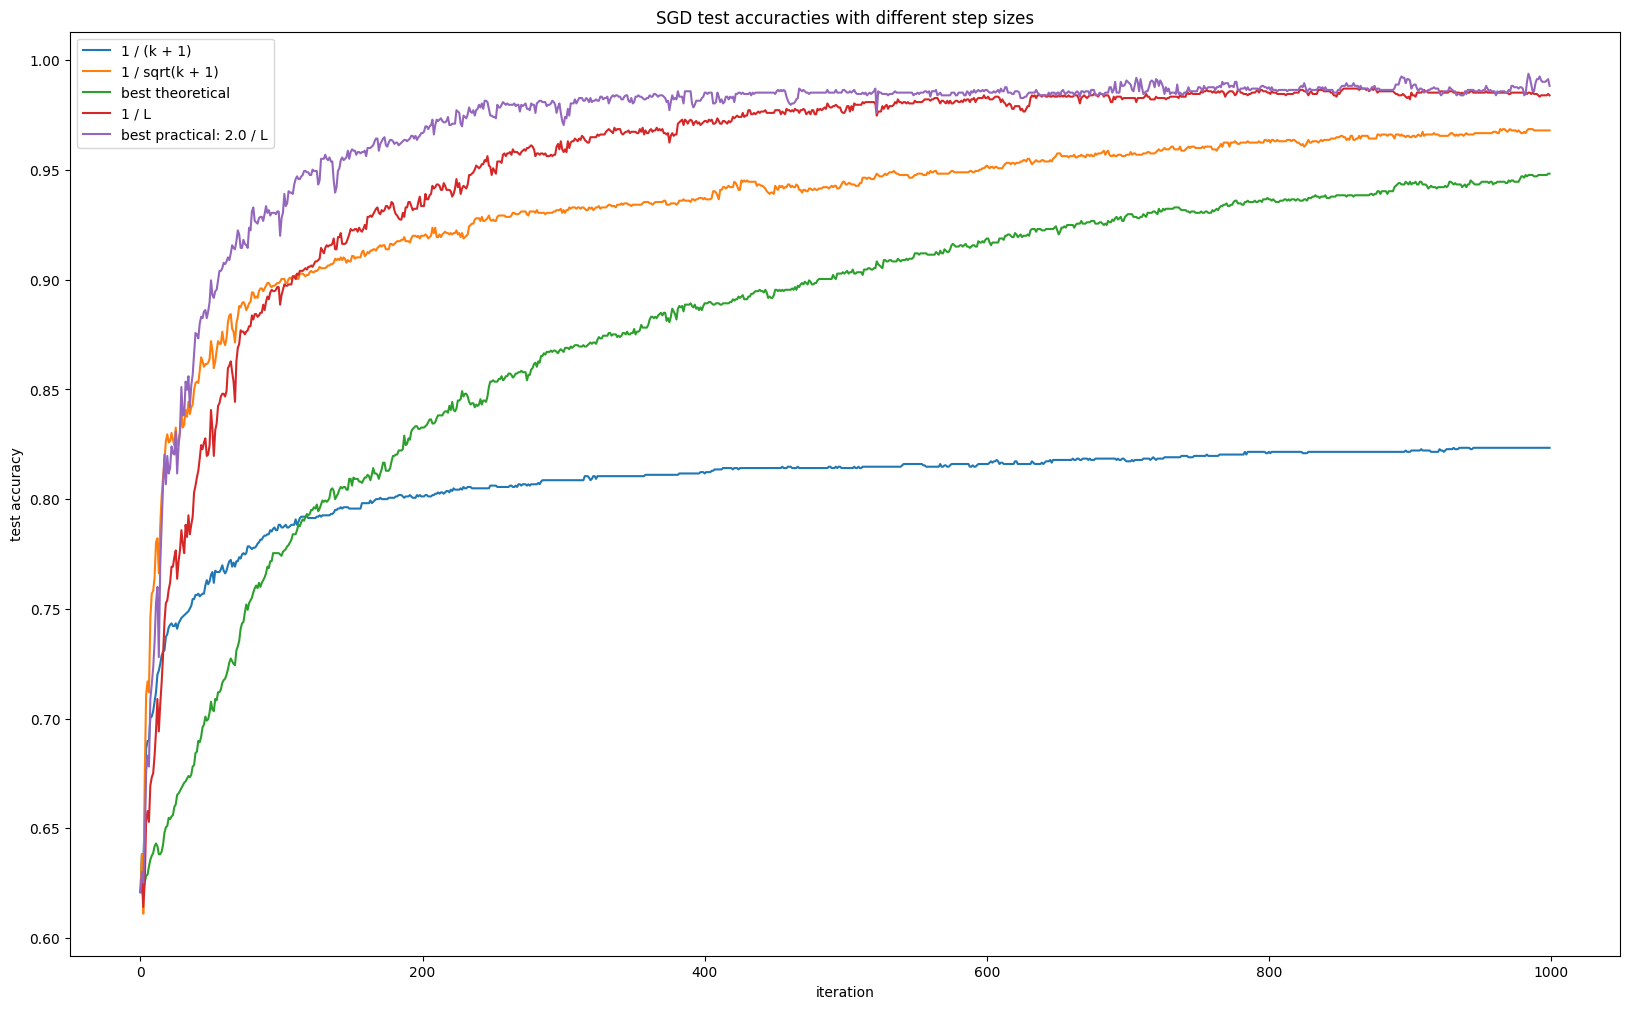

In [162]:
plt.figure(figsize=FIGURE_SIZE)
gamma_inverse_k = lambda  k : 1 / (k + 1)
gamma_inverse_square_k = lambda  k :1 / np.sqrt(k + 1)
gamma_best_SGD_THEORETICAL = lambda _ : BEST_GAMMA_SGD_THEORETICAL
gamma_best_SGD_PRACTICAL = lambda _ : BEST_GAMMA_SGD_PRACTICAL
gamma_constant_L_TILED  = lambda _ : 1 / L_TILED

gamma_labels = ['1 / (k + 1)', '1 / sqrt(k + 1)', 'best theoretical', '1 / L', f'best practical: {round(best_alpha, 3)} / L']

for gamma_function_obj, gamma_label in zip([gamma_inverse_k, gamma_inverse_square_k, gamma_best_SGD_THEORETICAL, gamma_constant_L_TILED, gamma_best_SGD_PRACTICAL], gamma_labels):
    x_points, criterions = simulation(data=X_train, 
                                    labels=y_train,
                                    data_batches=X_BATCHES,
                                    label_batches=Y_BATCHES, 
                                    optimization_algorithm=stoachastic_gradient_descent, 
                                    function=p1_stochastic_value,
                                    grad_function=p1_stochastic_grad,
                                    gamma_k=gamma_function_obj, 
                                    mode=normalized_criterion,
                                    K=10 ** 3)

    accuracies = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in x_points]
    plot_iterations(criterions=accuracies, 
                    x_label='iteration', 
                    y_label=f'test accuracy',
                    plot_label=f'{gamma_label}', 
                    show=False)    
  

plt.legend()
plt.title("SGD test accuracy with different step sizes")
plt.show()

### Conclusion:

1. We can see that SGD reaches similar accuracy for different batch sizes. This results aligns with the converges as SGD converges to very close values with different batch sizes
2. We can see that the results with accuracy also aligns with the converges as SGD reaches the highest accuracies with both $\frac{2}{L}$ and $\frac{1}{L}$


## f (30 points)__ 

Implement the 

SAGA (Section A.5 of [paper](https://arxiv.org/pdf/1905.11261.pdf)), 

SVRG (Section А.9 from [работы](https://arxiv.org/pdf/1905.11261.pdf)) and 

SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)) methods for our problem. 

Solve the optimization problem on the training sample using the new implemented methods. 

Take $b = 10$, and hyperparameters of methods according to the theory (see corresponding papers). 

Write these parameters. 

Is the iteration number a fair for comparison of these methods? 

Figure out how to compare the results more honestly (running time is a good option, but you can't use it here). 

Draw the comparison plots of SGD (with step $\gamma_k \equiv \frac{1}{\tilde L}$), SAGA, SVRG and SARAH: 

1) value of convergence criterion versus your criterion, 

2) accuracy of predictions versus your criterion. 

Make a conclusion.

I based my implementations on the original papers:

[SAGA](https://arxiv.org/pdf/1407.0202.pdf) 

[SVRG](https://proceedings.neurips.cc/paper/2013/file/ac1dd209cbcc5e5d1c6e28598e8cbbe8-Paper.pdf)

### Implementation

In [104]:
def saga(data: np.ndarray, 
        labels: np.ndarray,
        data_batches: Sequence[np.ndarray],
        label_batches: Sequence[np.ndarray],
        function: callable,
        grad_function: callable, 
        x_0: np.ndarray,                      
        x_sol: np.ndarray=None,
        K: int = 10 ** 3,
        eps: float = 10 ** -5, 
        mode: str = normalized_criterion,
        gamma_k: callable = None,                      
        return_history: bool = False
        ) -> Union[List[np.ndarray], np.ndarray]:
    
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

    x_0 = np.expand_dims(x_0) if x_0.ndim == 1 else x_0

    # create the array to save the gradient
    phi_grads = np.concatenate([grad_function(X=data_batches[i], y=label_batches[i], w=x_0).reshape(-1, 1) for i in range(len(data_batches))], axis=1)
    # at this point the i-th column of phi_grads contains the gradient on the ith batch with weight x_0

    x_current, x_previous = x_0, x_0
    x_history = [x_current]
    criterion_history = []

    for k in tqdm(range(K)):
        # save the k-th point: for comparison purposes mainly.
        x_previous = x_current

        # generate the data index randomly
        # data_index represents 'j' in the algorithm pseudo code
        data_index = random.randint(0, len(data_batches) - 1)

        # first extract the previous grad at 'data_index' 
        previous_phi_grad = phi_grads[:, [data_index]]    
        # previous_phi_grad: represents the delta_j phi_j^k        
        next_phi_grad = grad_function(X=data_batches[data_index], y=label_batches[data_index], w=x_current)
        phi_grad_avg = np.mean(phi_grads, axis=1).reshape(-1, 1)

        # calculate gamma
        gamma = gamma_k(k)
                
        # compute the (k+1)-th point    
        x_current = x_current - gamma * (next_phi_grad - previous_phi_grad + phi_grad_avg)

        # make sure to save the new phi gradient: 
        
        phi_grads[:, data_index] = next_phi_grad.squeeze()

        # create the arguments to pass to the function: the entire data
        func_args = {"X": data, 'y': labels, 'w': x_current}
        if mode == f_diff:
            diff = f_difference(function(func_args), function(func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args), ord=2) / norm(grad_function(**{"X": data, 'y': labels, 'w': x_0}), ord=2)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
        
        if diff <= eps: 
            break

    assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    # the function will all intermediate points if the 'return_history' argument is set to True
    # and only the last point otherwise    
    return (x_history, criterion_history) if return_history else x_history[-1]

In [105]:
def sgvr(data: np.ndarray, 
        labels: np.ndarray,
        data_batches: Sequence[np.ndarray],
        label_batches: Sequence[np.ndarray],
        function: callable,
        grad_function: callable, 
        x_0: np.ndarray,               
        update_frequency: int = None,       
        x_sol: np.ndarray=None,
        K: int = 10 ** 3,
        eps: float = 10 ** -5, 
        mode: str = normalized_criterion,
        gamma_k: callable = None,                      
        return_history: bool = False
        ) -> Union[List[np.ndarray], np.ndarray]:
    
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")


    if update_frequency is None:
        update_frequency = len(data_batches) // 2

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0

    x_history = [x_current]
    criterion_history = []

    for k in tqdm(range(int(math.ceil(K)))):
        # create the arguments to pass to the function: the entire data
        func_args = {"X": data, 'y': labels, 'w': x_current}

        # make sure to set 'x_previous' to 'x_current'
        x_previous = x_current.copy()
        # calculate gamma
        gamma = gamma_k(k)

        grad_data = grad_function(**func_args)

        w_current = x_current

        for _ in range(update_frequency):
            # sample the batch 
            data_index = random.randint(0, len(data_batches) - 1)
            batch_data, batch_label = data_batches[data_index], label_batches[data_index]
            w_current = w_current - gamma * (grad_function(X=batch_data, y=batch_label,w=w_current) - 
                                             grad_function(X=batch_data, y=batch_label, w=x_current) + 
                                             grad_data)
        
        # set the k-th x_current to w_m (option 1 in SVRG)
        x_current = w_current

        if mode == f_diff:
            diff = f_difference(function(func_args), function(func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args), ord=2) / norm(grad_function(**{"X": data, 'y': labels, 'w': x_0}), ord=2)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
            
        if diff <= eps: 
            break

        assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    # the function will all intermediate points if the 'return_history' argument is set to True
    # and only the last point otherwise    
    return (x_history, criterion_history) if return_history else x_history[-1]

In [106]:
def sarah(data: np.ndarray, 
        labels: np.ndarray,
        data_batches: Sequence[np.ndarray],
        label_batches: Sequence[np.ndarray],
        function: callable,
        grad_function: callable, 
        x_0: np.ndarray,               
        update_frequency: int = None,       
        x_sol: np.ndarray=None,
        K: int = 10 ** 3,
        eps: float = 10 ** -5, 
        mode: str = normalized_criterion,
        gamma_k: callable = None,                      
        return_history: bool = False
        ) -> Union[List[np.ndarray], np.ndarray]:
    
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")


    if update_frequency is None:
        update_frequency = len(data_batches) // 2

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0

    x_history = [x_current]
    criterion_history = []

    for k in tqdm(range(int(math.ceil(K)))):
        # create the arguments to pass to the function: the entire data
        func_args = {"X": data, 'y': labels, 'w': x_current}

        # make sure to set 'x_previous' to 'x_current'
        x_previous = x_current.copy()
        # calculate gamma
        gamma = gamma_k(k)

        # calculate the gradient over the entire data
        v_0 = grad_function(**func_args)

        # x_current now represents 'w_0': save it in 'ws'
        # perform the first gradient descent step:
        w1 = x_current - gamma * v_0
        ws = [x_current.copy(), w1]

        # w_previous reprsents w_{t-1}, w_current represents w_t
        w_previous, w_current= x_current.copy(), w1.copy()
        # v_current: represents v_0 at this point
        v_current = v_0.copy()

        for _ in range(update_frequency - 1):
            # sample the index of the batch  
            data_index = random.randint(0, len(data_batches) - 1)
            # extract the batch data and labels
            batch_data, batch_label = data_batches[data_index], label_batches[data_index]

            grad_wt = grad_function(X=batch_data, y=batch_label, w=w_current)
            grad_wt_1 = grad_function(X=batch_data, y=batch_label, w=w_previous)

            v_current = grad_wt - grad_wt_1 + v_current

            # save w_{t} to w_previous
            w_previous = w_current.copy()

            # calculate w_{t + 1} and save it to w_current
            w_current = w_current - gamma * v_current
        
            ws.append(w_current)

        # set the k-th x
        x_current = random.choice(ws)

        if mode == f_diff:
            diff = f_difference(function(func_args), function(func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args), ord=2) / norm(grad_function(**{"X": data, 'y': labels, 'w': x_0}), ord=2)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
            
        if diff <= eps: 
            break

        assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    # the function will all intermediate points if the 'return_history' argument is set to True
    # and only the last point otherwise    
    return (x_history, criterion_history) if return_history else x_history[-1]

### Hyperparameters

#### Saga
I am using the original SAGA paper as [reference](https://arxiv.org/pdf/1407.0202.pdf). 

The SAGA algorithm assumes that each function is $L$ smooth and $\mu$ strongly convex. we have already chosen ,
$$ 
\tilde{L}  = max(L, L_1, L_2, ... L_s)
$$

and for each $f_i$, we have $\mu = \lambda$.

The hyperparameters in the paper are: 

* step size: $\gamma = \frac{1}{2 \cdot (\mu \cdot \gamma  + L)}$ 

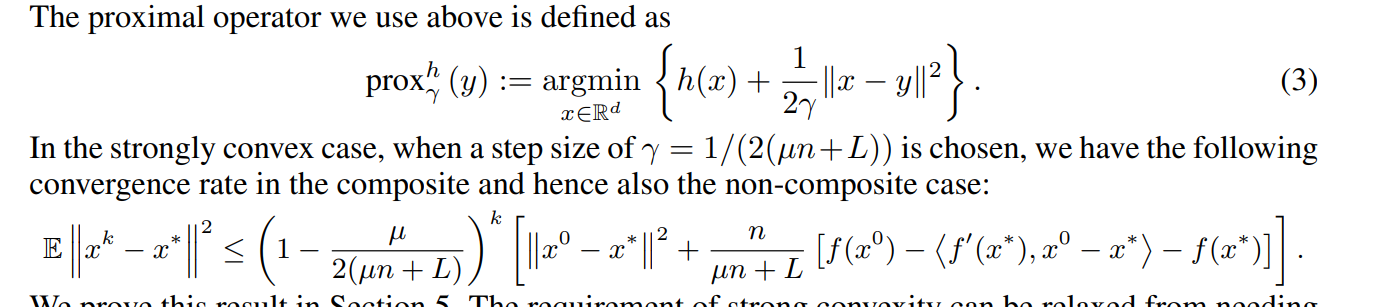

#### SVRG
I am using the original paper for [reference]()

There are 2 hyperparameters: 

* $m$ the update frequence (The parameters) are updated $m$ at each iteration / epoch
* $\gamma$ the step size 

The authors of the paper chose $\gamma = \frac{0.1}{L}$ and $m = O(n) = 2 \cdot n$. 

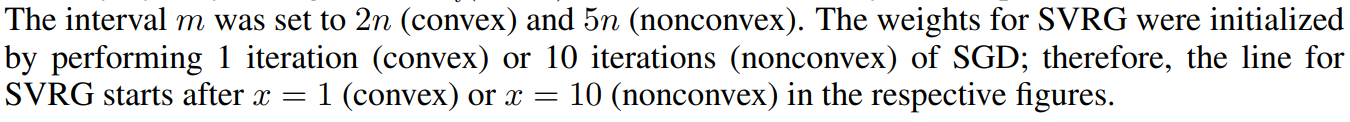

<!-- These 2 hyperparameters must be chosen such that:  -->
<!-- $$ \frac{1}{ \mu \cdot \gamma (1 - 2 L \gamma) \cdot m} + \frac{2 L \gamma }{1 - 2 L\gamma } < 1$$ -->

<!-- I will use the minimum number to satisfy the condition.
\begin{align*}
\frac{1}{ \mu \cdot \gamma (1 - 2 L \gamma) \cdot m} + \frac{2 L \gamma }{1 - 2 L\gamma } &< 1 \\
\implies \frac{1 + 2 L \gamma ^ 2 \cdot \mu \cdot m}{\mu \cdot \gamma (1 - 2 L \gamma) \cdot m} &< 1 \\
\implies 1 + 2 L \gamma ^ 2 \cdot \mu \cdot m & < \mu \cdot \gamma (1 - 2 L \gamma) \cdot m \\
\implies \frac{1}{\mu \cdot \gamma (1 - 4 L \gamma)} &< m
\end{align*} -->


#### SARAH
According to collary 3 of the paper, the authors choose: 

* a step size: $\frac{1}{2 L}$
* m: update frequency: $4.5 \cdot \kappa$

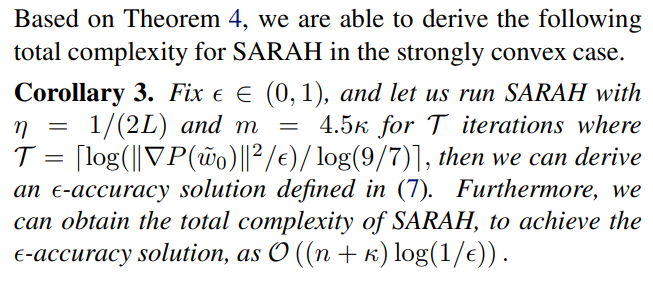

Since we are setting $\kappa = 1000$, $m$ will be $4500$ which is more than half the dataset.

According to  theorem $4$ in the paper, if: 

$$
\sigma_m = \frac{1}{\mu \gamma (m + 1)} + \frac{\gamma L}{2 - \gamma L} < 1 
$$

then SARAH guarantees a linear convergence.

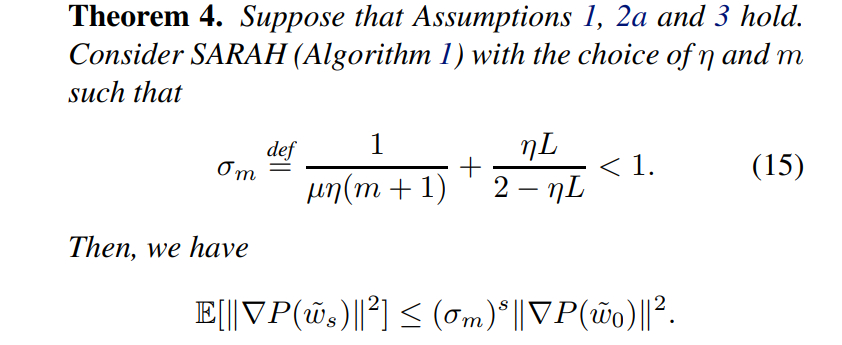


Let's find the minimal $m$ satisfying the inequality above for $\gamma = \frac{1}{2L}$

\begin{align}
\frac{1}{\frac{L}{1000} \cdot \frac{1}{2L} (m + 1)} + \frac{0.5}{1.5} &< 1 \\
\implies \frac{2000}{m + 1} &< \frac{2}{3} \\ 
\implies 3000 &\leq m
\end{align}

### Run the algorithms

In [107]:
import math
# let's prepare the data
# first let's split the data into batches to define the inner functions
X_10_BATCHES, Y_10_BATCHES = split_into_batches(X=X_train, y=y_train, batch_size=10, even_split=False)

L_TILED, REG_TILED = set_L_Reg(X_train, y_train, X_10_BATCHES, Y_10_BATCHES)

# a callable object with the main loss, gradient and hessian
p1_stochastic_value = partial(p1_value_function, lam=REG_TILED)
p1_stochastic_grad = partial(p1_gradient_function, lam=REG_TILED)

# the estimation of 'L'
assert abs(L_TILED / REG_TILED - 1000) <= 10

In [108]:
# find the step size for SAGA
SAGA_CONSTANT_GAMMA = lambda _: 1 / (2 * (REG_TILED * len(X_10_BATCHES) + L_TILED))

In [109]:
# find the step size for SVRG
SGVR_STEP_SIZE = 0.1 / L_TILED
SGVR_UPDATE_FREQ = 2 * len(X_10_BATCHES)
SGVR_CONSTANT_GAMMA = lambda _: SGVR_STEP_SIZE 

In [110]:
# let's create a function that finds the minimum value of 'm' for a given 'L' for the SARAH algorithm

def min_update_freq_sarah(mu: float, gamma: float, l: float, offset: int = 10) -> int:
    return int(math.ceil(1 / (mu * gamma * (1 - (gamma * l) / (2 - gamma * l))))) + offset

SARAH_STEP_SIZE = 1 / (2 * L_TILED)
SARAH_UPDATE_FREQUENCY = min_update_freq_sarah(mu=REG_TILED, l=L_TILED, gamma=SARAH_STEP_SIZE, offset=0)
SARAH_CONSTANT_GAMMA = lambda _: SARAH_STEP_SIZE

 79%|███████▉  | 793/1000 [00:04<00:01, 202.43it/s]

  2%|▏         | 23/1000 [00:04<03:22,  4.83it/s]


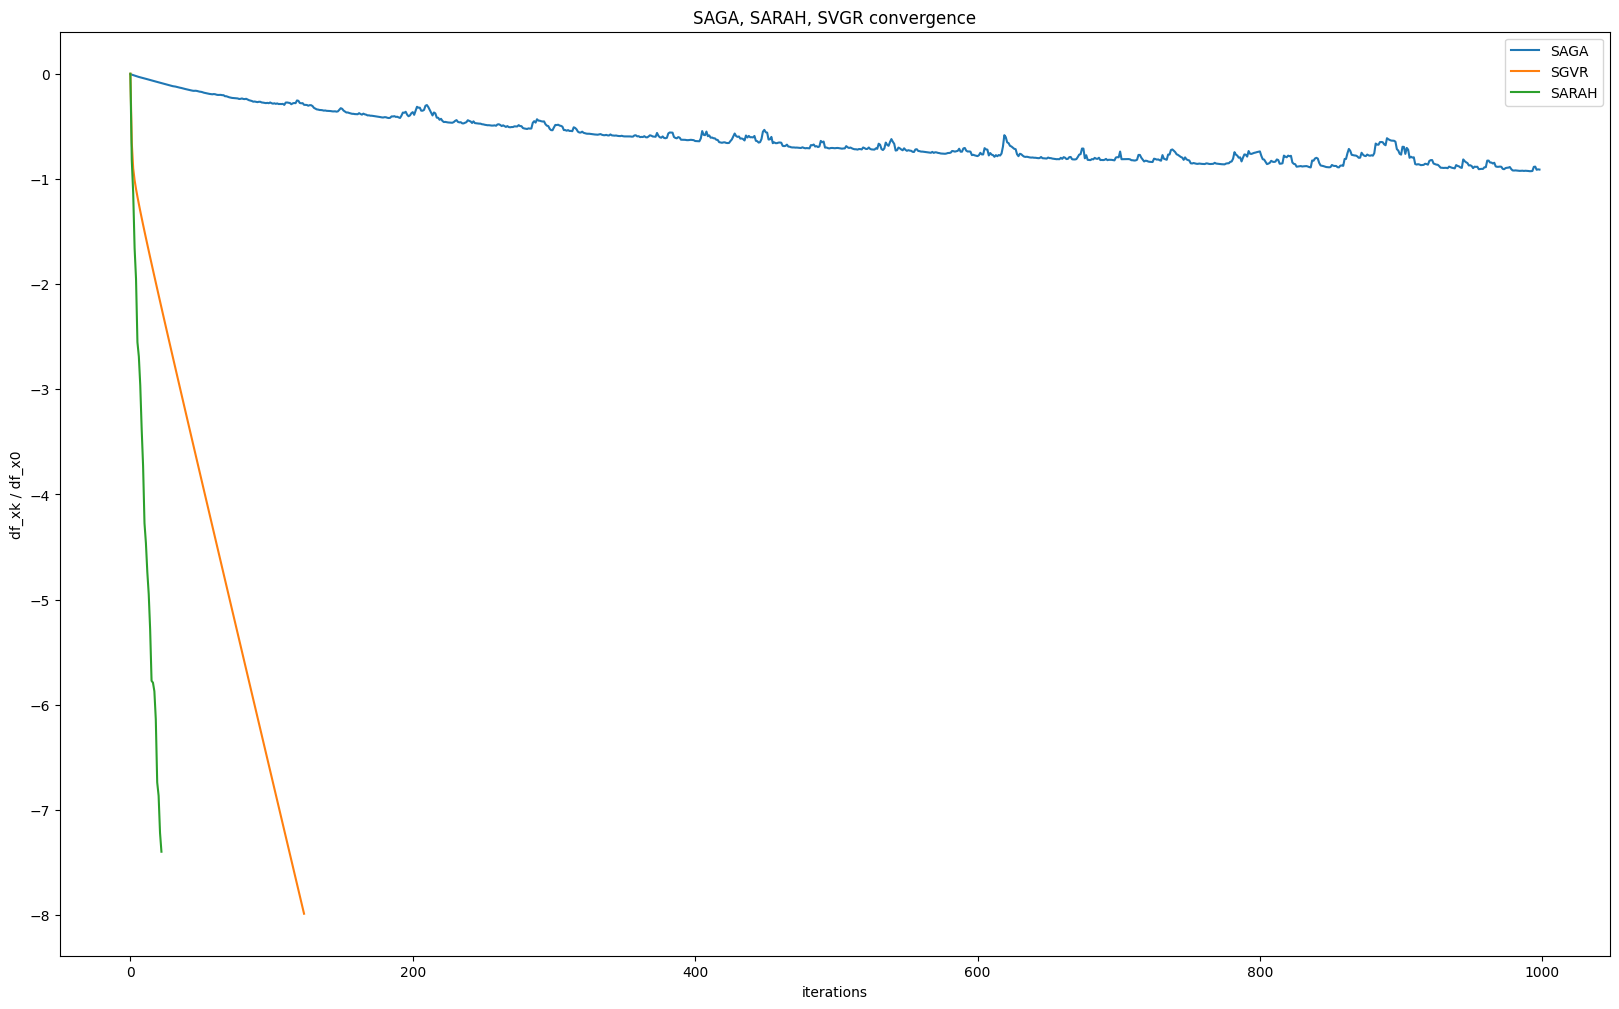

In [111]:
TOTAL_RUNS = 1000

# the constant gamma for SGD: 1 / L
constant_gamma_k = lambda _: 1 / L_TILED
plt.figure(figsize=FIGURE_SIZE)
accuracies = []

# run the simulation 
saga_xpoints, saga_criterions= simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                optimization_algorithm=saga, 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SAGA_CONSTANT_GAMMA, 
                                mode=normalized_criterion,
                                K=TOTAL_RUNS)

saga_criterions = [np.log10(c) for c in saga_criterions]
plot_iterations(criterions=saga_criterions,
                x_label='iterations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SAGA',
                show=False)


# run the simulation 
svrg_points, svrg_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency to the values calculated 
                                optimization_algorithm=partial(sgvr,update_frequency=SGVR_UPDATE_FREQ),  
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SGVR_CONSTANT_GAMMA, 
                                mode=normalized_criterion, 
                                K=TOTAL_RUNS)


svrg_criterions = [np.log10(c) for c in svrg_criterions]
plot_iterations(criterions=svrg_criterions, 
                x_label='iterations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SGVR',                
                show=False)


# run the simulation 
sarah_xpoints, sarah_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency
                                optimization_algorithm=partial(sarah, update_frequency=SARAH_UPDATE_FREQUENCY), 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SARAH_CONSTANT_GAMMA, 
                                mode=normalized_criterion,
                                K=TOTAL_RUNS)

sarah_criterions = [np.log10(c) for c in sarah_criterions]
plot_iterations(criterions=sarah_criterions, 
                x_label='iterations', 
                y_label=f'{normalized_criterion}', 
                plot_label='SARAH',
                show=False)

plt.legend()
plt.title("SAGA, SARAH, SVGR convergence")
plt.show()  

In [112]:
SGVR_UPDATE_FREQ, SARAH_UPDATE_FREQUENCY

(1300, 3003)

### Is the number of iterations a fair criterion ?

The number of iteration is not a fair criterion. SGD and SAGA are single loops algorithms. They compute the gradient only on one batch per iteration. On the other hand, SVRG And SARAH are double-loop algorithm. They compute gradients on $O(n + m)$ batches per iteration. To put this into perspective: $m$ is equal to 1300 and 3000 for SVRG and SARAH respectively. Thus, SVRG carries 1300 times more computations than SAGA and SGD given the same number of iterations.  

A possible fair criterion is number of batches processed / gradients computed 

I will run SGD and SAGA for $10 ^ 4$ iterations and SVRG and SARAH for only $10$ 

### Run the algorithms: gradient computations

100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


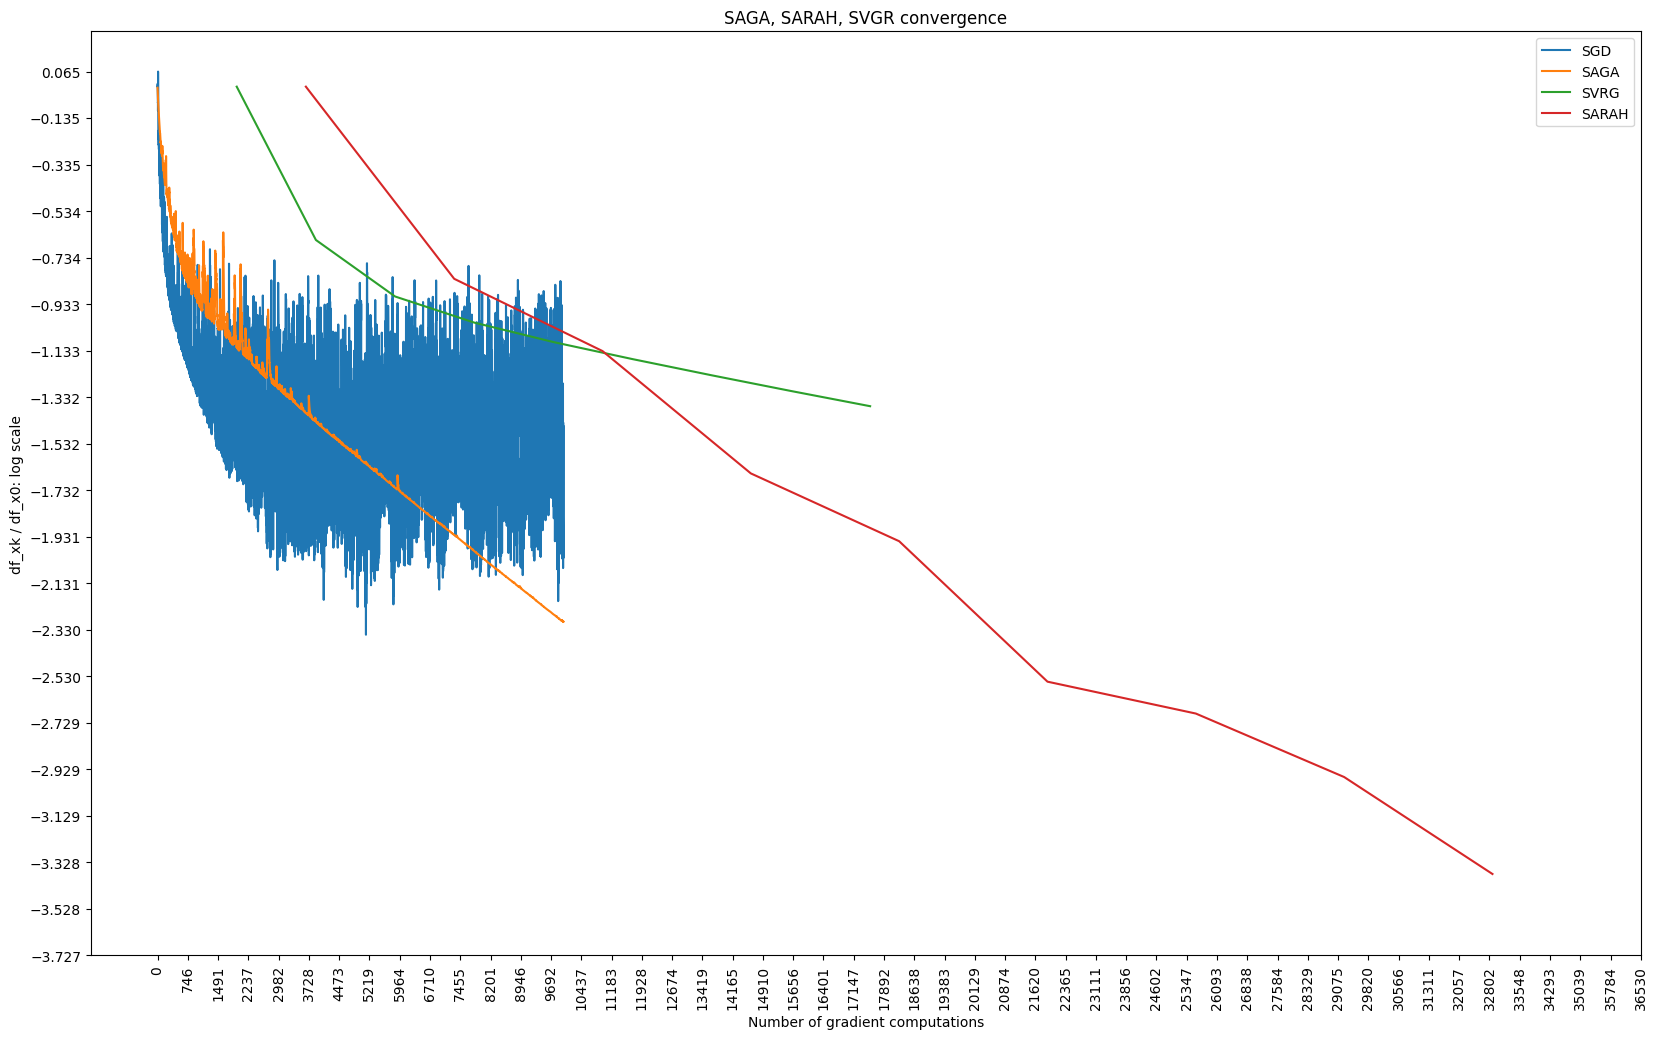

In [113]:
TOTAL_RUNS = 10 ** 4

# the constant gamma for SGD: 1 / L
constant_gamma_k = lambda _: 1 / L_TILED
plt.figure(figsize=FIGURE_SIZE)

# SGD:
sgd_xpoints, sgd_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                optimization_algorithm=stoachastic_gradient_descent, 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=constant_gamma_k, 
                                mode=normalized_criterion,
                                K=TOTAL_RUNS)

# convert the criterions to log scale
sgd_criterions = [np.log10(c) for c in sgd_criterions]
# calculate the accuracies
sgd_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in sgd_xpoints]
plot_iterations(criterions=sgd_criterions,
                x_label='iterations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SGD',
                show=False)


# SAGA
saga_xpoints, saga_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                optimization_algorithm=saga, 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SAGA_CONSTANT_GAMMA, 
                                mode=normalized_criterion,
                                K=TOTAL_RUNS)

# convert the criterions to log scale
saga_criterions = [np.log10(c) for c in saga_criterions]
# calculate the accuracies
saga_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in saga_xpoints]
plot_iterations(criterions=saga_criterions,
                x_label='Number of gradient computations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SAGA',
                show=False)

# run the simulation 
svrg_points, svrg_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency to the values calculated 
                                optimization_algorithm=partial(sgvr,update_frequency=SGVR_UPDATE_FREQ),  
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SGVR_CONSTANT_GAMMA, 
                                mode=normalized_criterion, 
                                K=10)

# convert the criterions to log scale
svrg_criterions = [np.log10(c) for c in svrg_criterions]
# calculate the accuracies
svrg_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in svrg_points]
svrg_xs = [(i + 1) * (SGVR_UPDATE_FREQ + len(X_10_BATCHES)) for i in range(len(svrg_criterions))]

plot_iterations(criterions=svrg_criterions,
                xs=svrg_xs,
                x_label='Number of gradient computations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SVRG',
                show=False)

# run the simulation 
sarah_xpoints, sarah_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency
                                optimization_algorithm=partial(sarah, update_frequency=SARAH_UPDATE_FREQUENCY), 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SARAH_CONSTANT_GAMMA, 
                                mode=normalized_criterion,
                                K=10)

sarah_xs = [(i + 1) * (SARAH_UPDATE_FREQUENCY + len(X_10_BATCHES)) for i in range(len(sarah_criterions))]
# convert the criterions to log scale
sarah_criterions = [np.log10(c) for c in sarah_criterions]
# calculate the accuracies
sarah_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in sarah_xpoints]
plot_iterations(criterions=sarah_criterions,
                xs=sarah_xs,
                x_label='Number of gradient computations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SARAH',
                show=False)

# set the xticks for better readability
xticks = np.linspace(0, max(max(sarah_xs), max(svrg_xs)), num=50)
plt.xticks(xticks, rotation=90)

# set the yticks for better readability
min_criterion = min([min(sgd_criterions), min(saga_criterions), min(svrg_criterions), min(sarah_criterions)])
max_criterion = max([max(sgd_criterions), max(saga_criterions), max(svrg_criterions), max(sarah_criterions)])
plt.yticks(np.linspace(max_criterion, min_criterion, num=20))
plt.legend()
plt.title("SAGA, SARAH, SVGR convergence")
plt.show()  

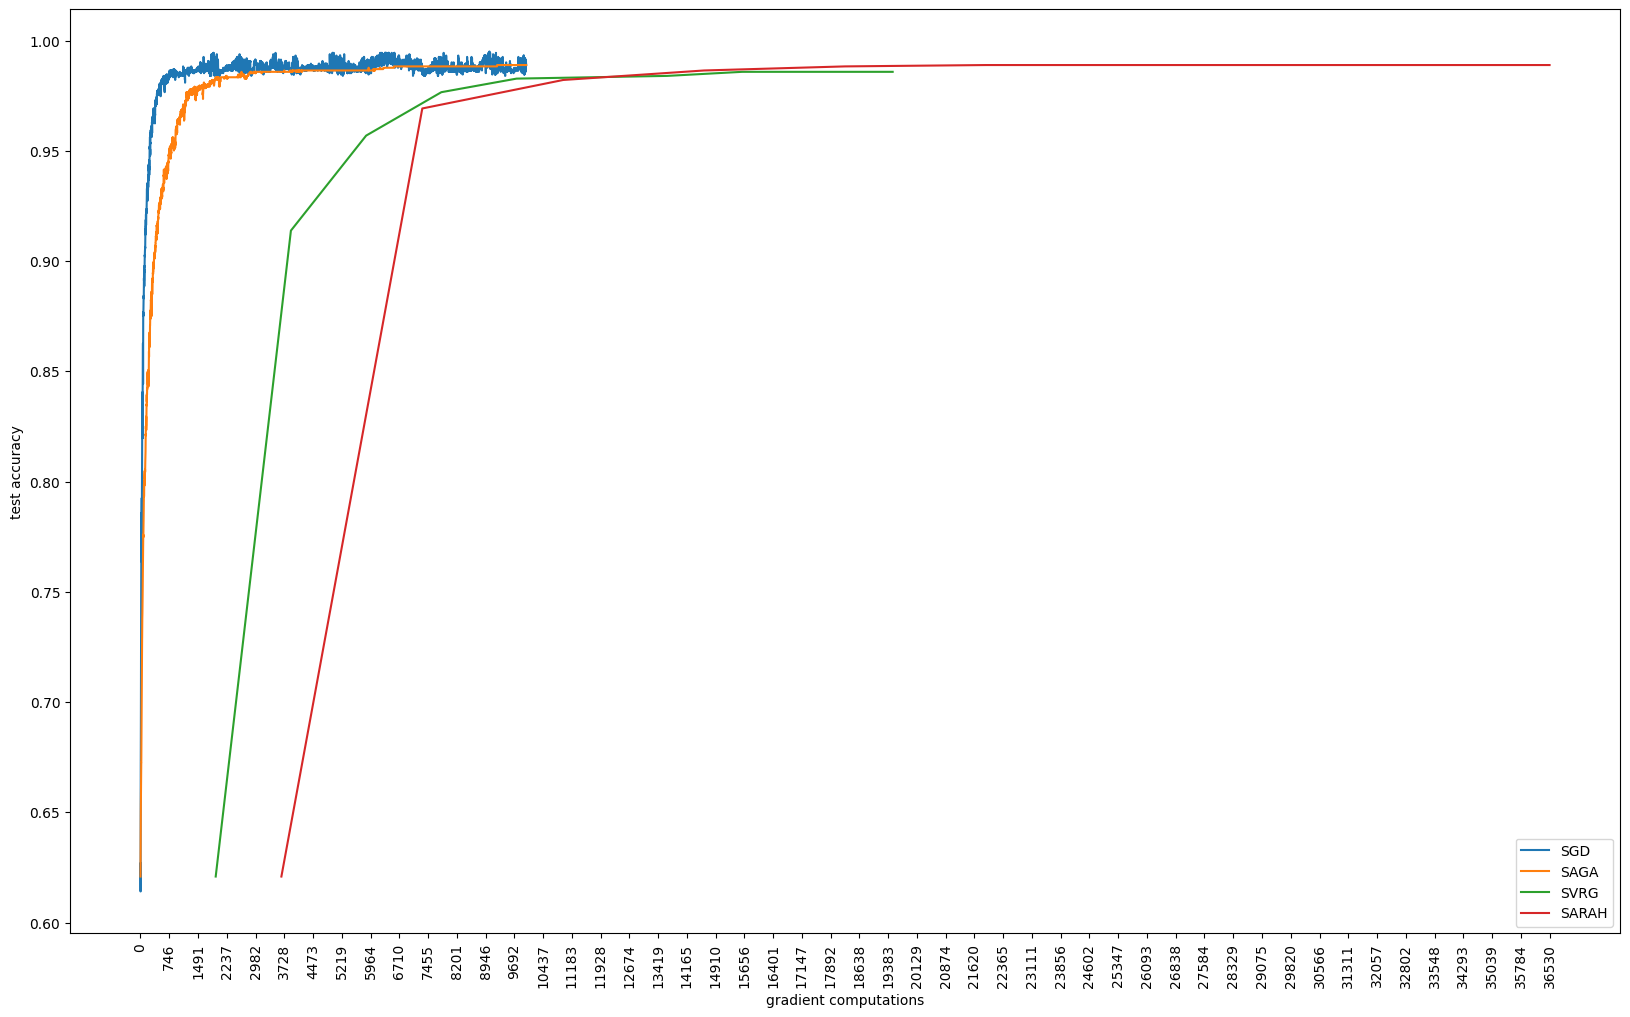

In [114]:
plt.figure(figsize=FIGURE_SIZE)
for accs, xs, label in zip([sgd_accs, saga_accs, svrg_accs, sarah_accs], [None, None, svrg_xs, sarah_xs], ['SGD', 'SAGA', 'SVRG', 'SARAH']):
    plot_iterations(accs, xs=xs, plot_label=label, x_label='gradient computations', y_label='test accuracy', show=False)

xticks = np.linspace(0, max(max(sarah_xs), max(svrg_xs)), num=50)
plt.xticks(xticks, rotation=90)
plt.legend()
plt.show()

### Conclusion

1. We can see that SAGA performs the best in terms of computed gradients. It also overcomes the main issue with SGD converging to a a neighborhood of the minimum point.
2. The major issue with SVRG is that $m$ is generally defined in terms of $n$. In other words, SVRG will generally iterate over the entire data per iteration which is not computationally efficient mainly when it is significantly outperformed by SARAH
3. The value of $m$ is SARAH is independent of $n$. Then SARAH is more likely to generalize to larger problems where $n$ is significantly large.

4. All algorithms reach a local minimum that is sufficient to reach high accuracy. 


###  Best steps

As in d.2), find the "best" step for SAGA, SVRG, SARAH. 

Draw the comparison plots for SGD, SAGA, SVRG, SARAH with the "best" steps: 

1) convergence criterion value, 

2) prediction accuracy. 

Make a conclusion.

I will use the same practical approach to find the 'best' step size as in the previous questions: Grid Search. I will use the theory from the papers to determine the search space.

SAGA: The authors prove that the linear convergence rate is guarteed for 

* $\gamma_1 = \frac{1}{2 (\mu n + L)}$ 
* $\gamma_2 = \frac{1}{3(\mu n + L)}$ (with relaxiation of certain assumptions). 

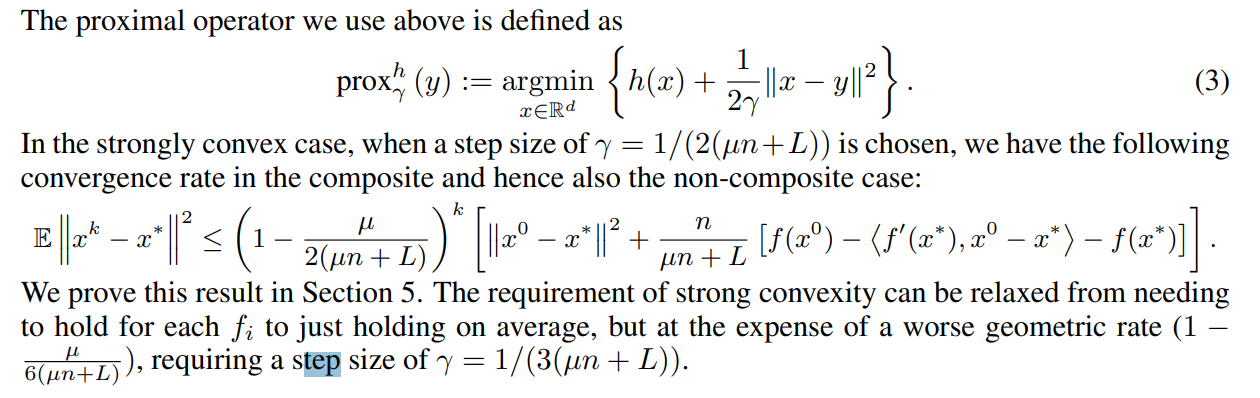


It is reasonable to consider the possible values of $\gamma = \frac{1}{ \alpha (\mu n + L)}$ where $\alpha \in (2, 3)$

SVRG: 
Going through the convergence analysis of the SVRG algorithm, the only restriction is $\gamma < \frac{2}{L}$ (so that the term $\alpha$ (in the image below) is positive). Additionally, the others suggest that $\gamma$ can be generally chosen as: $O(1 / L)$

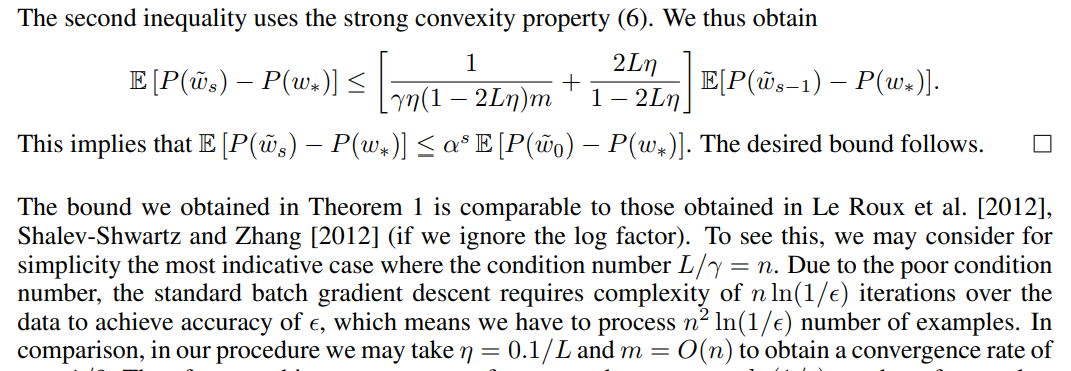

SARAH: 
the authors suggest that any $\gamma < \frac{1}{L}$ can work for SARAH (under the assumption that $m$ is chosen properly). 

For SARAH I will consider $\frac{\alpha}{L}$ where $\alpha \in (0.1, 0.9)$.

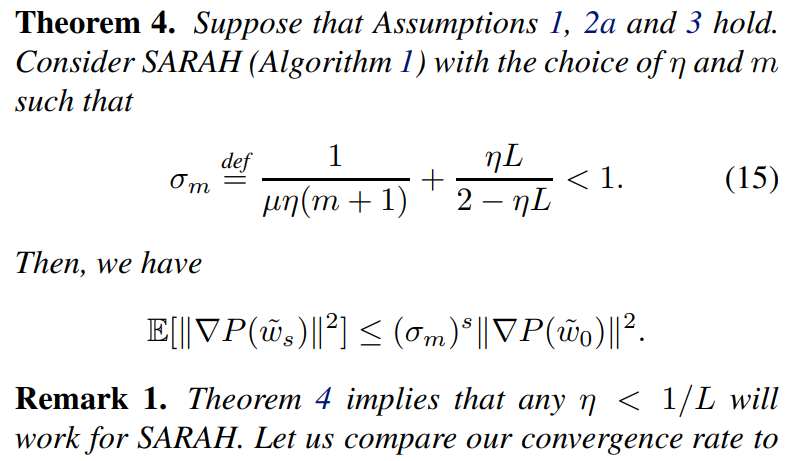


In [115]:
best_gamma, min_criterion = None, float('inf')

for param in np.linspace(2, 3, num=10):
    gamma = (param * (REG_TILED * len(X_10_BATCHES) + L_TILED))
    gamma_func_obj = lambda _ : gamma
    _, criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency to the values calculated 
                                optimization_algorithm=saga,  
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=gamma_func_obj, 
                                mode=normalized_criterion, 
                                K=10 ** 3)
    
    if min(criterions) < min_criterion:
        min_criterion = min(criterions)
        best_gamma = gamma

BEST_SAGA_GAMMA = lambda _: best_gamma 

100%|██████████| 1000/1000 [00:04<00:00, 233.96it/s]


In [116]:
best_gamma, min_criterion = None, float('inf')

for param in np.linspace(0.05, 0.25):
    gamma = param / L_TILED
    gamma_func_obj = lambda _ : gamma
    _, criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency to the values calculated 
                                optimization_algorithm=partial(sgvr, update_frequency=SGVR_UPDATE_FREQ),  
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=gamma_func_obj, 
                                mode=normalized_criterion, 
                                K=10)
    
    if min(criterions) < min_criterion:
        min_criterion = min(criterions)
        best_gamma = gamma

BEST_SVRG_GAMMA = lambda _ : best_gamma

100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


In [117]:
best_gamma, min_criterion, update_freq = None, float('inf'), 0

for param in np.linspace(0.1, 0.9):
    gamma = param / L_TILED
    gamma_func_obj = lambda _ : gamma

    temp_update_freq = min_update_freq_sarah(mu=REG_TILED, l=L_TILED, gamma=gamma)
    _, criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency to the values calculated 
                                optimization_algorithm=partial(sarah, update_frequency=temp_update_freq),  
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=gamma_func_obj, 
                                mode=normalized_criterion, 
                                K=10)
    
    if min(criterions) < min_criterion:
        min_criterion = min(criterions)
        best_gamma = gamma
        update_freq = temp_update_freq

BEST_SVRG_GAMMA = lambda _ : best_gamma
BEST_UPDATE_FREQ = update_freq

 90%|█████████ | 9/10 [00:03<00:00,  2.36it/s]


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


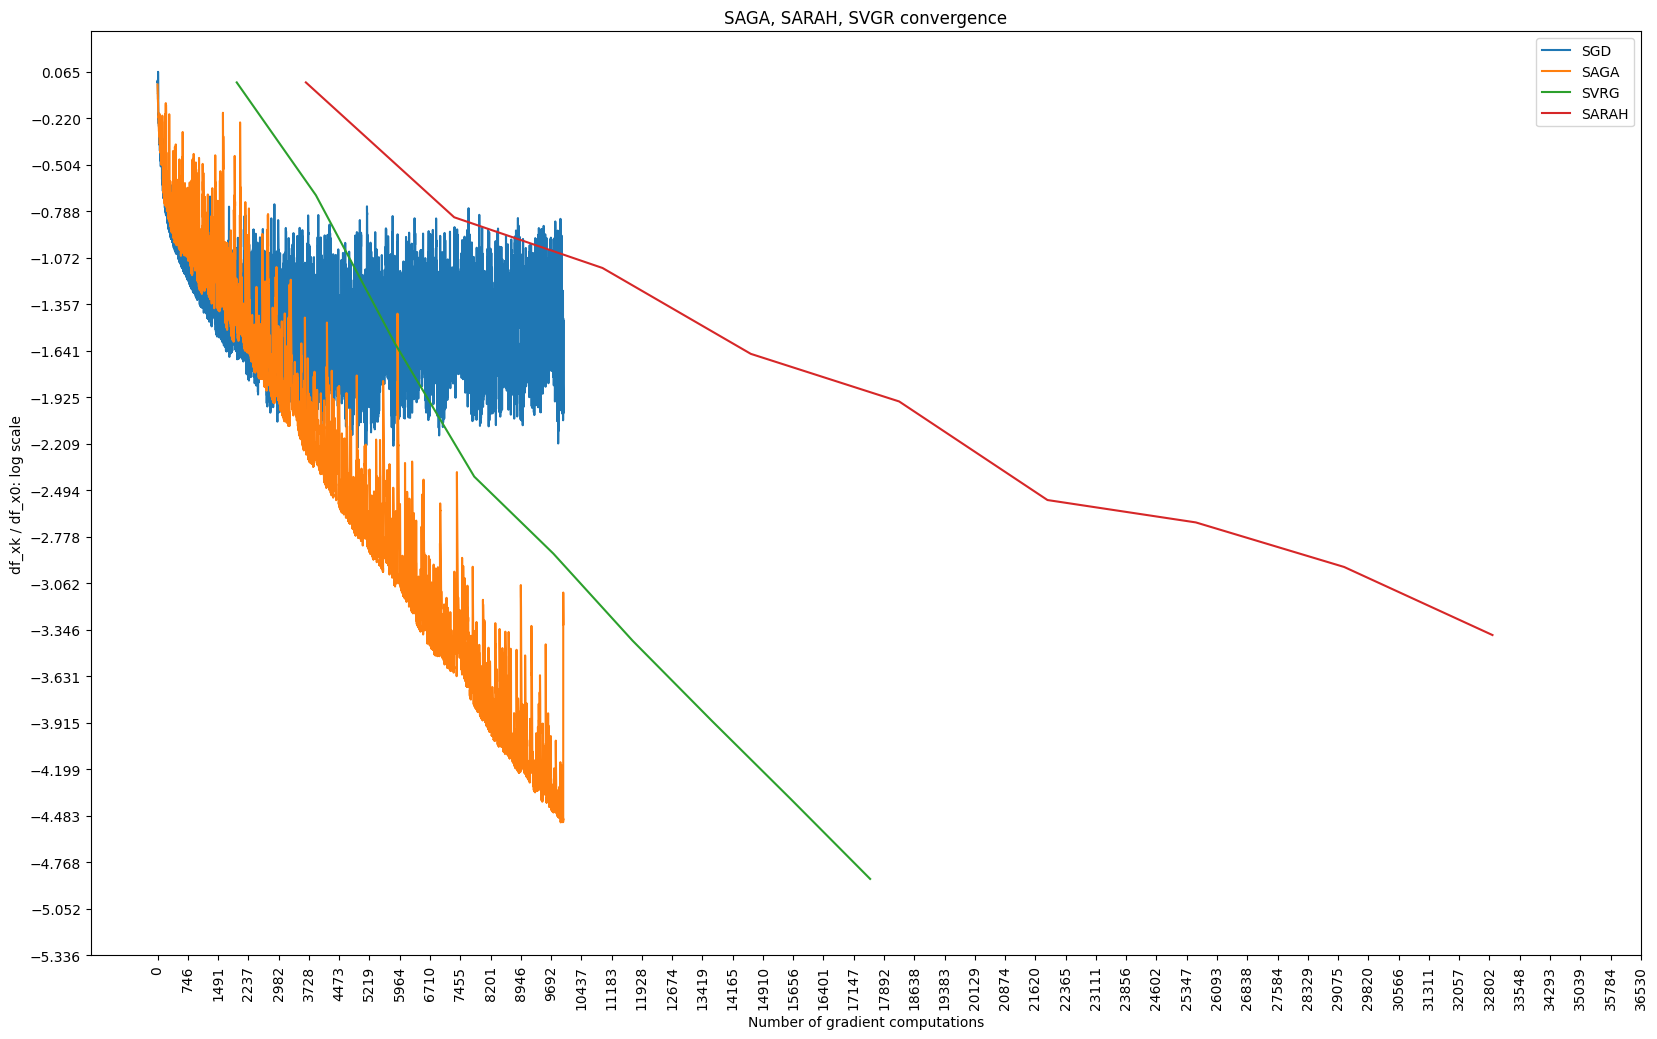

In [118]:
TOTAL_RUNS = 10 ** 4

# the constant gamma for SGD: 1 / L
constant_gamma_k = lambda _: 1 / L_TILED
plt.figure(figsize=FIGURE_SIZE)

# SGD:
sgd_xpoints, sgd_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                optimization_algorithm=stoachastic_gradient_descent, 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=constant_gamma_k, 
                                mode=normalized_criterion,
                                K=TOTAL_RUNS)

# convert the criterions to log scale
sgd_criterions = [np.log10(c) for c in sgd_criterions]
# calculate the accuracies
sgd_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in sgd_xpoints]
plot_iterations(criterions=sgd_criterions,
                x_label='iterations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SGD',
                show=False)


# SAGA
saga_xpoints, saga_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                optimization_algorithm=saga, 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                # make sure to use the 'best' step size
                                gamma_k=BEST_SAGA_GAMMA, 
                                mode=normalized_criterion,
                                K=TOTAL_RUNS)

# convert the criterions to log scale
saga_criterions = [np.log10(c) for c in saga_criterions]
# calculate the accuracies
saga_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in saga_xpoints]
plot_iterations(criterions=saga_criterions,
                x_label='Number of gradient computations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SAGA',
                show=False)

# run the simulation 
svrg_points, svrg_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency to the values calculated 
                                optimization_algorithm=partial(sgvr,update_frequency=SGVR_UPDATE_FREQ),  
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=BEST_SVRG_GAMMA, 
                                mode=normalized_criterion, 
                                K=10)

# convert the criterions to log scale
svrg_criterions = [np.log10(c) for c in svrg_criterions]
# calculate the accuracies
svrg_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in svrg_points]
svrg_xs = [(i + 1) * (SGVR_UPDATE_FREQ + len(X_10_BATCHES)) for i in range(len(svrg_criterions))]

plot_iterations(criterions=svrg_criterions,
                xs=svrg_xs,
                x_label='Number of gradient computations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SVRG',
                show=False)

# run the simulation 
sarah_xpoints, sarah_criterions = simulation(
                                data=X_train, 
                                labels=y_train,
                                data_batches=X_10_BATCHES,
                                label_batches=Y_10_BATCHES, 
                                # make sure to set the update frequency
                                optimization_algorithm=partial(sarah, update_frequency=SARAH_UPDATE_FREQUENCY), 
                                function=p1_stochastic_value,
                                grad_function=p1_stochastic_grad,
                                gamma_k=SARAH_CONSTANT_GAMMA, 
                                mode=normalized_criterion,
                                K=10)

sarah_xs = [(i + 1) * (SARAH_UPDATE_FREQUENCY + len(X_10_BATCHES)) for i in range(len(sarah_criterions))]
# convert the criterions to log scale
sarah_criterions = [np.log10(c) for c in sarah_criterions]
# calculate the accuracies
sarah_accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in sarah_xpoints]
plot_iterations(criterions=sarah_criterions,
                xs=sarah_xs,
                x_label='Number of gradient computations', 
                y_label=f'{normalized_criterion}: log scale', 
                plot_label='SARAH',
                show=False)

# set the xticks for better readability
xticks = np.linspace(0, max(max(sarah_xs), max(svrg_xs)), num=50)
plt.xticks(xticks, rotation=90)

# set the yticks for better readability
min_criterion = min([min(sgd_criterions), min(saga_criterions), min(svrg_criterions), min(sarah_criterions)])
max_criterion = max([max(sgd_criterions), max(saga_criterions), max(svrg_criterions), max(sarah_criterions)])
plt.yticks(np.linspace(max_criterion, min_criterion, num=20))
plt.legend()
plt.title("SAGA, SARAH, SVGR convergence")
plt.show()  

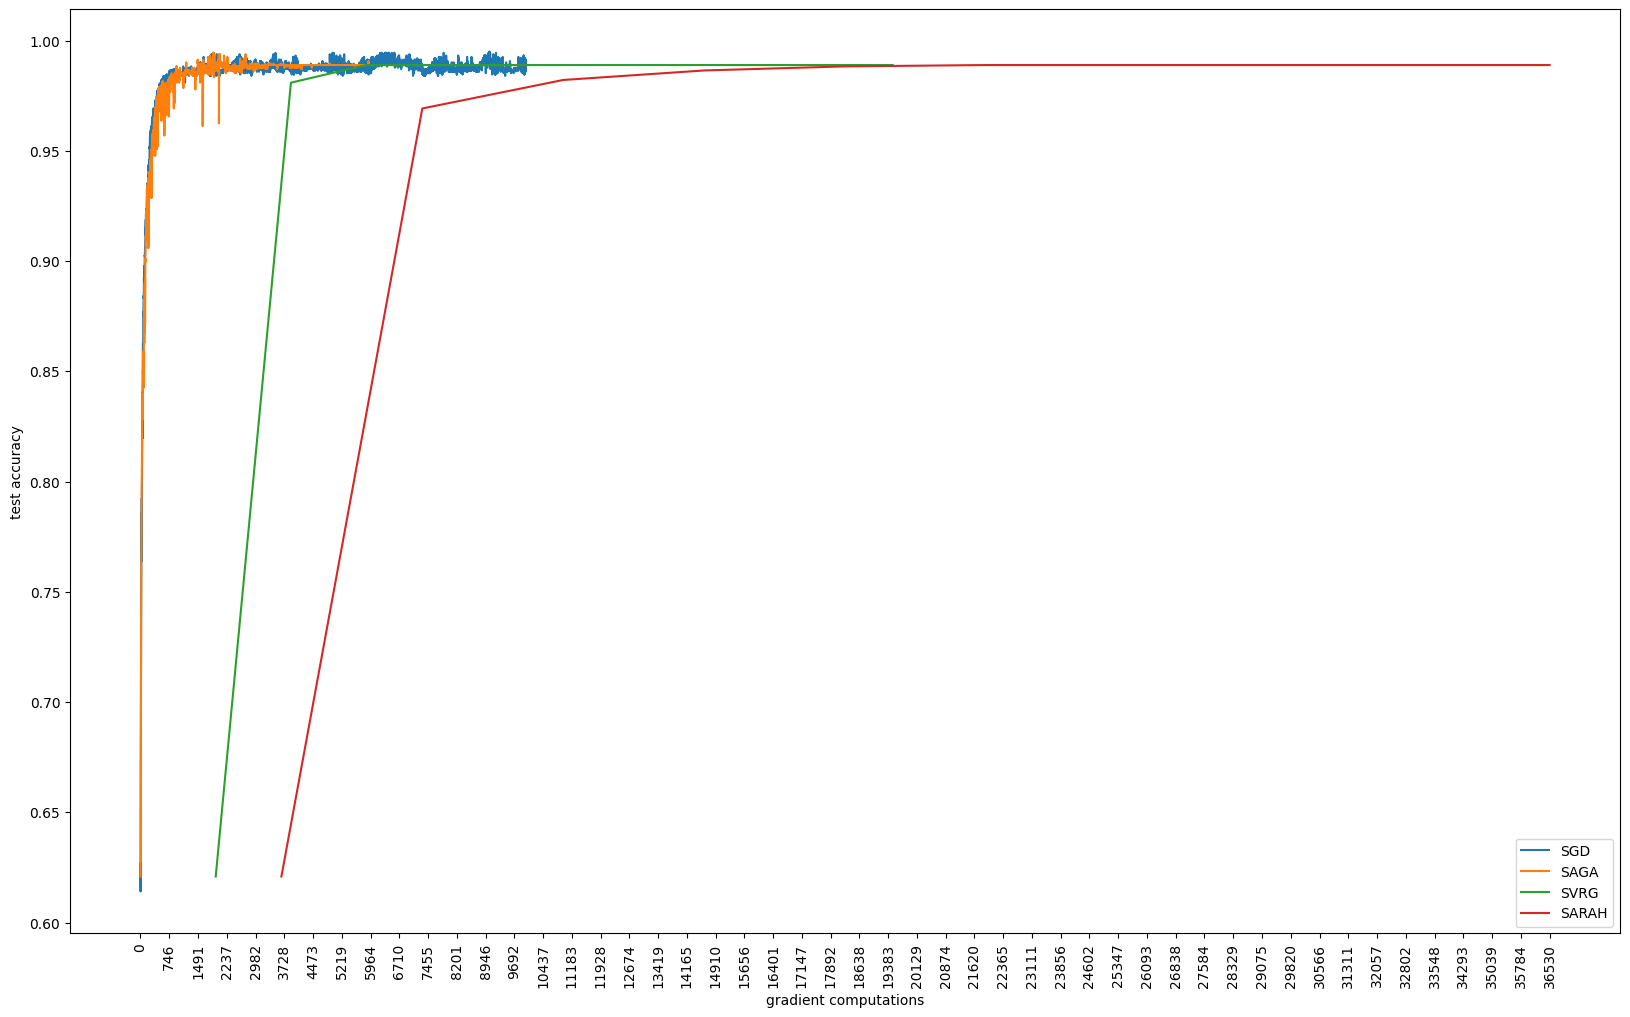

In [119]:
plt.figure(figsize=FIGURE_SIZE)
for accs, xs, label in zip([sgd_accs, saga_accs, svrg_accs, sarah_accs], [None, None, svrg_xs, sarah_xs], ['SGD', 'SAGA', 'SVRG', 'SARAH']):
    plot_iterations(accs, xs=xs, plot_label=label, x_label='gradient computations', y_label='test accuracy', show=False)

xticks = np.linspace(0, max(max(sarah_xs), max(svrg_xs)), num=50)
plt.xticks(xticks, rotation=90)
plt.legend()
plt.show()

### Conclusion

* WE can see that SAGA is still the leading algorithm (performance in terms of gradient computations). Surprisingly enough, SVRG outperforms SARAH after fine-tuning the step size. This seems to align with the remarks shared in the SARAH paper: SVRG might be more difficult to tune that SARAH since SARAH's convergence improved but only slightly while SVRG improved significanlty with the newly chosen step size. 

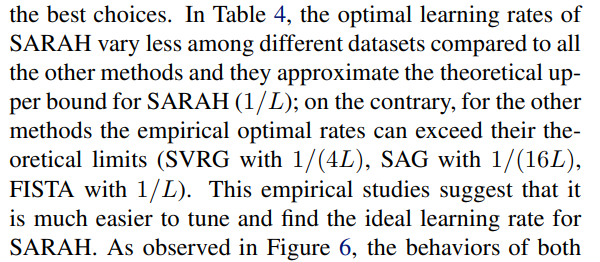

# Problem 2. (25 points)__ 
This part of the assignment is related to __distributed with compression__ methods.  

Let us simulate a distributed  environment. To do this, divide the training sample randomly and uniformly into $s=10$ parts (this was implemented in Problem 0). 

In [92]:
# split the entire data into devices
device_size = int(math.ceil(len(X_train) / 10))
DEVICES_DATA, DEVICES_LABELS = split_into_batches(X=X_train, y=y_train, even_split=False, batch_size=device_size)

In [93]:
len(DEVICES_DATA), len(DEVICES_LABELS)

(10, 10)

In [95]:
L_TILED, REG_TILED = set_L_Reg(X_train, y_train, DEVICES_DATA, DEVICES_LABELS)

# a callable object with the main loss, gradient and hessian
p2_distributed_function = partial(p1_value_function, lam=REG_TILED)
p2_distributed_grad = partial(p1_gradient_function, lam=REG_TILED)

# the estimation of 'L'
assert abs(L_TILED / REG_TILED - 1000) <= 10

## а). (5 points) 
Implement the $\text{Rand}k$ and $\text{Top}k$ compression operators, where $k$ is a parameter. 

In [163]:
def random_k_compression(x: np.ndarray, k: Union[int, float], column_vector: bool = True) -> np.ndarray:
    if x.ndim > 2:
        raise ValueError(f"the input is expected to be a batch of 1 dimensional samples")

    if x.ndim == 1:
        x = np.expand_dims(x, axis=-1)  
    
    if column_vector:
        x = x.T

    if isinstance(k, float) and k >= 1: 
        raise ValueError(f"Found float coefficient larger than {1}: {k}. Expected either {int} or {float} less than 1")

    k = k if isinstance(k, int) else int(math.ceil(k * x.shape[1]))

    # each column will represent a vector to compress  
    coordinates = set(random.sample(population=range(x.shape[1]), k=k))

    mask = np.asarray([[1 if index in coordinates else 0 for index in range(x.shape[1])] for _ in range(x.shape[0])])

    compressed_x = x * mask * (x.shape[1] / k)

    if column_vector:
        return compressed_x.T
    
    return compressed_x


def top_k_compression(x: np.ndarray, k: Union[int, float], column_vector: bool = True) -> np.ndarray:
    if x.ndim > 2:
        raise ValueError(f"the input is expected to be a batch of 1 dimensional samples")

    if x.ndim == 1:
        x = np.expand_dims(x, axis=-1)  
    
    if column_vector:
        x = x.T
    
    if isinstance(k, float) and k >= 1: 
        raise ValueError(f"Found float coefficient larger than {1}: {k}. Expected either {int} or {float} less than 1")

    k = k if isinstance(k, int) else int(math.ceil(k * x.shape[1]))


    indices = np.argsort(x, axis=1)
    indices = indices[:, -k:]
    if indices.shape != (x.shape[0], k): 
        raise ValueError(f"check the number of indices to be extracted. Expected: {k, x.shape[1]}. Found: {indices.shape}")

    mask = np.asarray([[1 if index in set(idx) else 0 for index in range(x.shape[1])] for idx in indices], dtype=np.float32) 

    compressed_x = x * mask

    if column_vector:
        return compressed_x.T
    
    return compressed_x


x = np.random.randint(0, 20, size=(5, 5))
print(x)
print("#" * 50)
print(top_k_compression(x, k=0.1, column_vector=True))
print("#" * 50)
print(random_k_compression(x, k=2, column_vector=True))


[[ 3 15 19 13  8]
 [16 19  0  4  9]
 [ 6 15 17 18 12]
 [16 11  0 11 17]
 [ 9  9 11  8 15]]
##################################################
[[ 0.  0. 19.  0.  0.]
 [ 0. 19.  0.  0.  0.]
 [ 0.  0.  0. 18.  0.]
 [16.  0.  0.  0. 17.]
 [ 0.  0.  0.  0.  0.]]
##################################################
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [40.  27.5  0.  27.5 42.5]
 [22.5 22.5 27.5 20.  37.5]]


## b). (10 points) 

Implement simple distributed gradient descent with compression operators. 

Compress information only from the devices to the server. 

Use compression operators $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. As in d.2) of Problem 1, find the "best" steps for all cases. 

Draw the comparison plots with these "best" steps: 

1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 
2) prediction accuracy versus number of transmitted coordinates from the devices to the server. 

Make a conclusion.

In [170]:
# create a class to represent the local devices
class DistributedCompressionDevice:
    def __init__(self,
                gradient_function: callable, 
                data: np.ndarray,
                labels: np.ndarray,
                compression_function: callable
                 ) -> None:
        self.data = data
        self.labels = labels
        self.gradient_function = gradient_function 
        self.comp = compression_function

    def local_grad(self, x_current: np.ndarray) -> np.ndarray:
        grad = self.gradient_function(self.data, self.labels, x_current)
        # compress the gradient and return 
        # self.comp(grad)
        comp_grad = self.comp(grad)
        return comp_grad           

In [171]:
import math
def regular_distributed_gd(
                    data: np.ndarray,
                    labels: np.ndarray,
                    devices_data: Sequence[np.ndarray],
                    devices_labels: Sequence[np.ndarray],
                    function: callable,
                    grad_function: callable,
                    compression_function: callable,
                    x_0: np.ndarray,
                    x_sol: np.ndarray=None,
                    K: int = 10 ** 3,
                    eps: float = 10 ** -5, 
                    mode: str = normalized_criterion,
                    gamma_k: callable = None,                      
                    return_history: bool = False
                    ) -> Union[List[np.ndarray], np.ndarray]:
    
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0
    x_history = [x_current]
    criterion_history = []

    # first of all let's define the local devices:assign a split of the data to each device
    devices = [DistributedCompressionDevice(gradient_function=grad_function, 
                                            data=d_data, 
                                            labels=d_labels, 
                                            compression_function=compression_function) for d_data, d_labels in zip(devices_data, devices_labels)]    


    for k in tqdm(range(K)):
        x_previous = x_current.copy()

        mean_compressed_grad = np.mean([dev.local_grad(x_current=x_current) for dev in devices], axis=0).reshape(-1, 1)

        # update with the mean of compressed gradients
        x_current = x_current - gamma_k(k) * mean_compressed_grad

        func_args = {"X": data, "y": labels, 'w': x_current}

        if mode == f_diff:
            diff = f_difference(function(**func_args), function(**func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args)) / norm(grad_function(**{"X": data, 'y': labels, 'w': x_0}))
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
            
        if diff <= eps: 
            break

        assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    # the function returns all intermediate points if the 'return_history' argument is set to True
    # and only the last point otherwise    
    return (x_history, criterion_history) if return_history else x_history[-1]


In [172]:
# let's find the best step size for each compression algorithm
def best_compression_step_size(compression_percentage: float, 
                               step_sizes: List[float], 
                               compression_function: callable,
                               iterations_per_step: int = 100) -> float:
    # define the operator
    compression_operator = partial(compression_function, k=compression_percentage)
    best_step_size = None
    min_criterion = float('inf')
    for s in step_sizes:
        # define the callable gamma
        callable_gamma = lambda _ : s
        x_0 = set_up()
        _, criterions = regular_distributed_gd(
                                    data=X_train,
                                    labels=y_train,
                                    devices_data=DEVICES_DATA,
                                    devices_labels=DEVICES_LABELS,
                                    function=p2_distributed_function,
                                    grad_function=p2_distributed_grad,
                                    compression_function=compression_operator,
                                    x_0=x_0,
                                    gamma_k=callable_gamma,
                                    mode=normalized_criterion, 
                                    return_history=True,
                                    K=iterations_per_step
                                    )           
        if min(criterions) < min_criterion: 
            min_criterion = min(criterions)
            best_step_size = s
    
    return best_step_size
        

In [173]:
COMPRESSION_PERCENTAGES = [0.01, 0.05, 0.1, 0.2]

# find the best step size for each compression 
best_random_comp_step_sizes = [best_compression_step_size(compression_percentage=c, 
                                              step_sizes=np.linspace(0.5, 1, num=5) / L_TILED, 
                                              compression_function=random_k_compression,
                                              iterations_per_step=1000)
                    for c in COMPRESSION_PERCENTAGES]

print({k: round(v, 3) for k, v in zip(COMPRESSION_PERCENTAGES, best_random_comp_step_sizes)})

100%|██████████| 1000/1000 [00:12<00:00, 80.91it/s]

{0.01: 0.19, 0.05: 0.19, 0.1: 0.19, 0.2: 0.19}


  0%|          | 5/1000 [00:00<00:21, 45.39it/s]

100%|██████████| 1000/1000 [00:12<00:00, 80.04it/s]


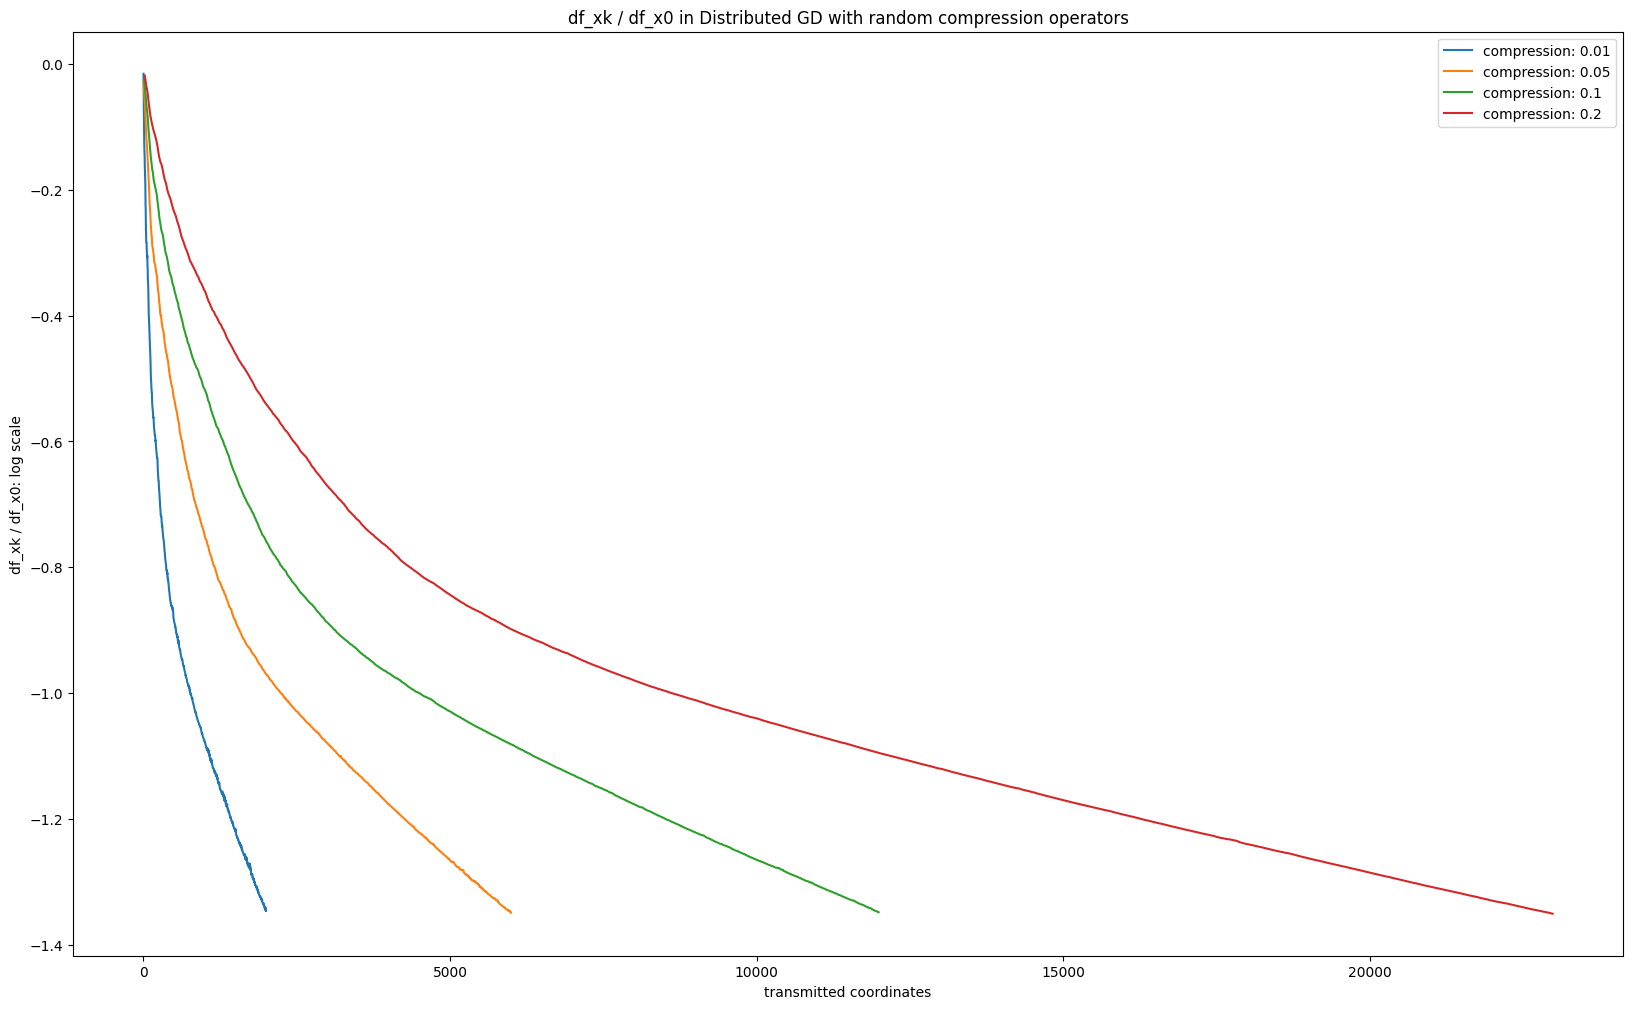

In [101]:
plt.figure(figsize=FIGURE_SIZE)
compression_xpoints = []

for c, s in zip(COMPRESSION_PERCENTAGES, best_random_comp_step_sizes):   
    # define gamma
    gamma_k = lambda _: s
    # create the function
    compression_function = partial(random_k_compression, k=c, column_vector=True)
    x_0 = set_up()
    x_points, criterions = regular_distributed_gd(
                                data=X_train,
                                labels=y_train,
                                devices_data=DEVICES_DATA,
                                devices_labels=DEVICES_LABELS,
                                function=p2_distributed_function,
                                grad_function=p2_distributed_grad,
                                compression_function=compression_function,
                                x_0=x_0,
                                gamma_k=gamma_k,
                                mode=normalized_criterion, 
                                return_history=True,
                                ) 
    trans_coordinates = int(math.ceil(c * X_train.shape[1]))
    criterions = [np.log10(c) for c in criterions]
    plot_iterations(criterions=criterions,
                    xs=[(i + 1) * trans_coordinates for i in range(len(criterions))],
                    x_label='transmitted coordinates', 
                    y_label=f'{normalized_criterion}: log scale', 
                    plot_label=f'compression: {round(c, 3)}',
                    show=False)

    compression_xpoints.append(x_points)
    

plt.legend()
plt.title(f"{normalized_criterion} in Distributed GD with random compression operators")
plt.show()     

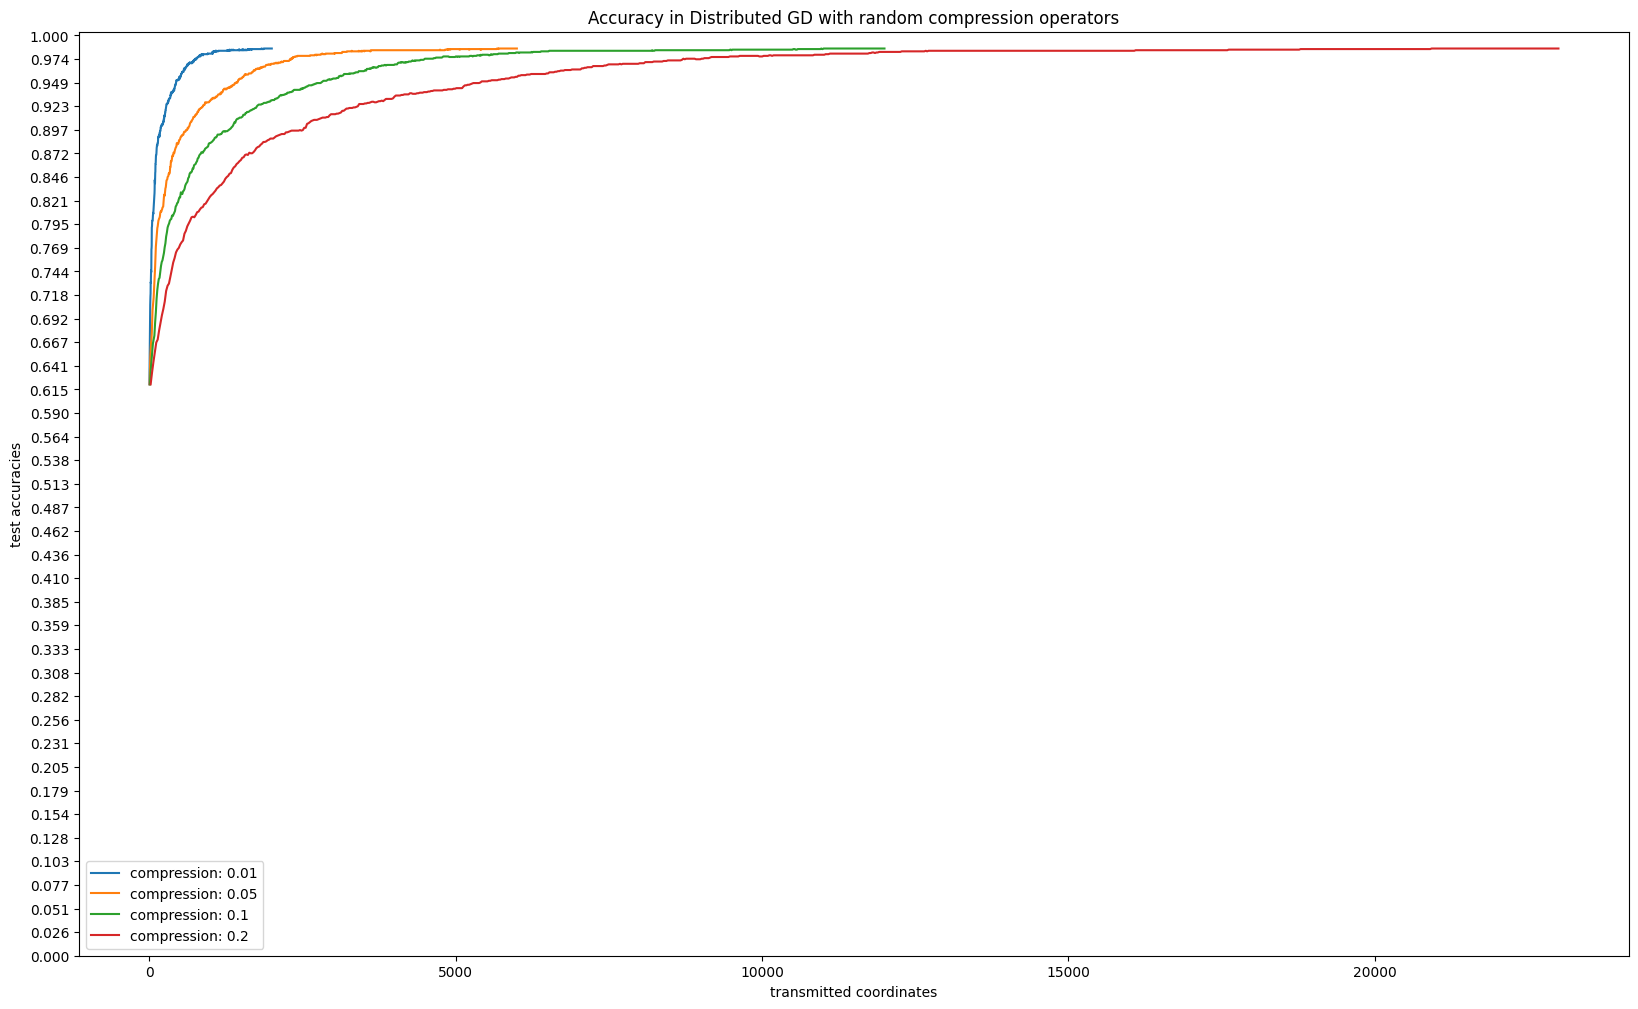

In [104]:
plt.figure(figsize=FIGURE_SIZE)
for cxpnts, c in zip(compression_xpoints, COMPRESSION_PERCENTAGES):
    trans_coordinates = int(math.ceil(c * X_train.shape[1]))
    accuracies = [calculate_accuracy(predictions=predict(w=x, X=X_test), labels=y_test) for x in cxpnts]
    plot_iterations(criterions=accuracies, 
                    xs=[(i + 1) * trans_coordinates for i in range(len(criterions))],
                    x_label='transmitted coordinates', 
                    y_label=f'test accuracies', 
                    plot_label=f'compression: {round(c, 3)}',
                    show=False)


plt.yticks(np.linspace(0, 1, num=40))
plt.legend()
plt.title(f"Accuracy in Distributed GD with random compression operators")
plt.show()

### Conclusion

The experiments conducted above suggest that the information preserved by the different compression operators do not differ significantly as the algorithms converge to the same neighbor and achieve very close accuracies.


## c). (10 points)

Now we use $\text{Top}10\%$ as compression operators. 

Compress the information only from the devices to the server. 

Use two methods: regular distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). 

For each method, select the step for the "best" convergence. 

Draw the comparison plots with these "best" steps: 

1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 
2) prediction accuracy versus number of transmitted coordinates from the devices to the server. 

Make a conclusion.

In [174]:
class DistributedErrorFeedbackDevice:
    def __init__(self, 
                 gradient_function: callable, 
                 data: np.ndarray,
                 labels: np.ndarray,
                 compression_function: callable
                 ) -> None:
        
        self.data = data
        self.labels = labels
        self.gradient_function = gradient_function 
        self.comp = compression_function
        self.error = np.zeros((data.shape[1], 1))

    def local_grad(self, x_current: np.ndarray, step_size: float) -> np.ndarray:  
        # compute the gradient with the local data
        grad = self.gradient_function(self.data,self.labels,x_current)
        # compute the compressed gradient
        compressed_grad = self.comp(self.error + step_size * grad)
        # update the error
        self.error =  self.error + step_size * grad - compressed_grad
        return compressed_grad    

In [175]:
def distributed_gradient_error_feedback(
                                data: np.ndarray,
                                labels: np.ndarray,
                                devices_data: Sequence[np.ndarray],
                                devices_labels: Sequence[np.ndarray],
                                function: callable,
                                grad_function: callable,
                                compression_function: callable,
                                x_0: np.ndarray,
                                weights: np.ndarray = None,
                                x_sol: np.ndarray=None,
                                K: int = 10 ** 3,
                                eps: float = 10 ** -5, 
                                mode: str = normalized_criterion,
                                gamma_k: callable = None,                      
                                return_history: bool = False
                                ) -> Union[List[np.ndarray], np.ndarray]:
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

    # define each of the devices
    devices = [DistributedErrorFeedbackDevice(gradient_function=grad_function, 
                                 data=d_data, 
                                 labels=d_labels, 
                                 compression_function=compression_function) 
                for d_data, d_labels in zip(devices_data, devices_labels)]

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0.copy()
    x_history = [x_current]
    criterion_history = []

    for k in tqdm(range(K)):
        x_previous = x_current.copy()

        gamma = gamma_k(k)

        mean_compressed_grad = np.mean([dev.local_grad(x_current=x_current, step_size=gamma) for dev in devices], axis=0).reshape(-1, 1)

        # update the weights by deducting the averge of the compressed gradients: MAKE SURE NOT TO MULTIPLY BY GAMMA.
        x_current = x_current - mean_compressed_grad

        func_args = {"X": data, "y": labels, 'w': x_current}

        if mode == f_diff:
            diff = f_difference(function(**func_args), function(**func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args), ord=2) / norm(grad_function(data, labels, x_0), ord=2)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else:
            # average the previous x_is
            x_bar = np.mean(x_history, axis=0).reshape(-1, 1)
            # the last case is where the criterion is passed as an argument
            diff = mode(x_bar)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
            
        if diff <= eps: 
            break

        assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    # the default weights are 1's for all values.
    weights = weights if weights is not None else np.ones(shape=(K + 1, 1))
    # add another dimension if needed
    weights = np.expand_dims(weights, axis=-1) if weights.ndim == 1 else weights

    # unlike most methods, this function uses a weighted average as the numerical solutio
    weighted_result = np.concatenate([x for x in x_history], axis=1) @ weights / np.sum(weights)

    return (weighted_result, x_history, criterion_history) if return_history else weighted_result

In [176]:
# define the compression function
TOP_10_COMPRESSION = partial(top_k_compression, k=0.1, column_vector=True)

# let's find the best step sizes for both algorithms
best_step_size, min_criterion = None, float('inf')

for alpha in np.linspace(0.5, 2, num=2):
    step_size = alpha / L_TILED
    # define the callable gamma
    callable_gamma = lambda _ : s
    x_0 = set_up()
    _, criterions = regular_distributed_gd(
                                data=X_train,
                                labels=y_train,
                                devices_data=DEVICES_DATA,
                                devices_labels=DEVICES_LABELS,
                                function=p2_distributed_function,
                                grad_function=p2_distributed_grad,
                                compression_function=TOP_10_COMPRESSION,
                                x_0=x_0,
                                gamma_k=callable_gamma,
                                mode=normalized_criterion, 
                                return_history=True,
                                K=10 ** 3
                                )           
    if min(criterions) < min_criterion: 
        min_criterion = min(criterions)
        best_step_size = s
    
TOP10_STEP_SIZE = best_step_size

100%|██████████| 1000/1000 [00:14<00:00, 69.01it/s]


We will consider the case of constant step size and equal weights. As indicated by the image below, for $\gamma \leq \frac{1}{14 (2\delta + B)L}$ we have linear convergence.

As for $B$ it might be difficult to estimate, then we will optimistically assume $B = 1$. On the other hand, we know that the compression compression operator belongs to $\mathbb{B}^3(\frac{d}{k})$ setting $detla = \frac{d}{k}$

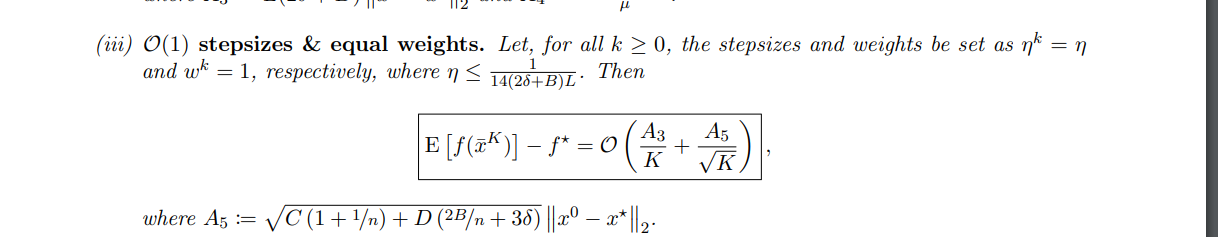

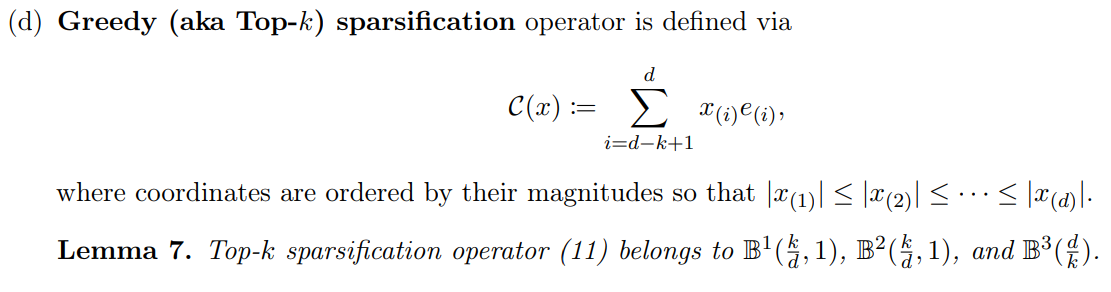

In [177]:
best_step_size, min_criterion = None, float('inf')

for alpha in np.linspace(14, 24, num=2):
    step_size = 1/ (alpha * (21) * L_TILED)
    # define the callable gamma
    callable_gamma = lambda _ : s
    x_0 = set_up()
    _, _, criterions = distributed_gradient_error_feedback(
                                data=X_train,
                                labels=y_train,
                                devices_data=DEVICES_DATA,
                                devices_labels=DEVICES_LABELS,
                                function=p2_distributed_function,
                                grad_function=p2_distributed_grad,
                                compression_function=TOP_10_COMPRESSION,
                                x_0=x_0,
                                gamma_k=callable_gamma,
                                mode=normalized_criterion, 
                                return_history=True,
                                K=10 ** 3
                                )           
    if min(criterions) < min_criterion: 
        min_criterion = min(criterions)
        best_step_size = s
    
ERROR_FEEDBACK_BEST_SIZE = best_step_size

100%|██████████| 1000/1000 [00:19<00:00, 51.32it/s]


100%|██████████| 1000/1000 [00:14<00:00, 69.53it/s]


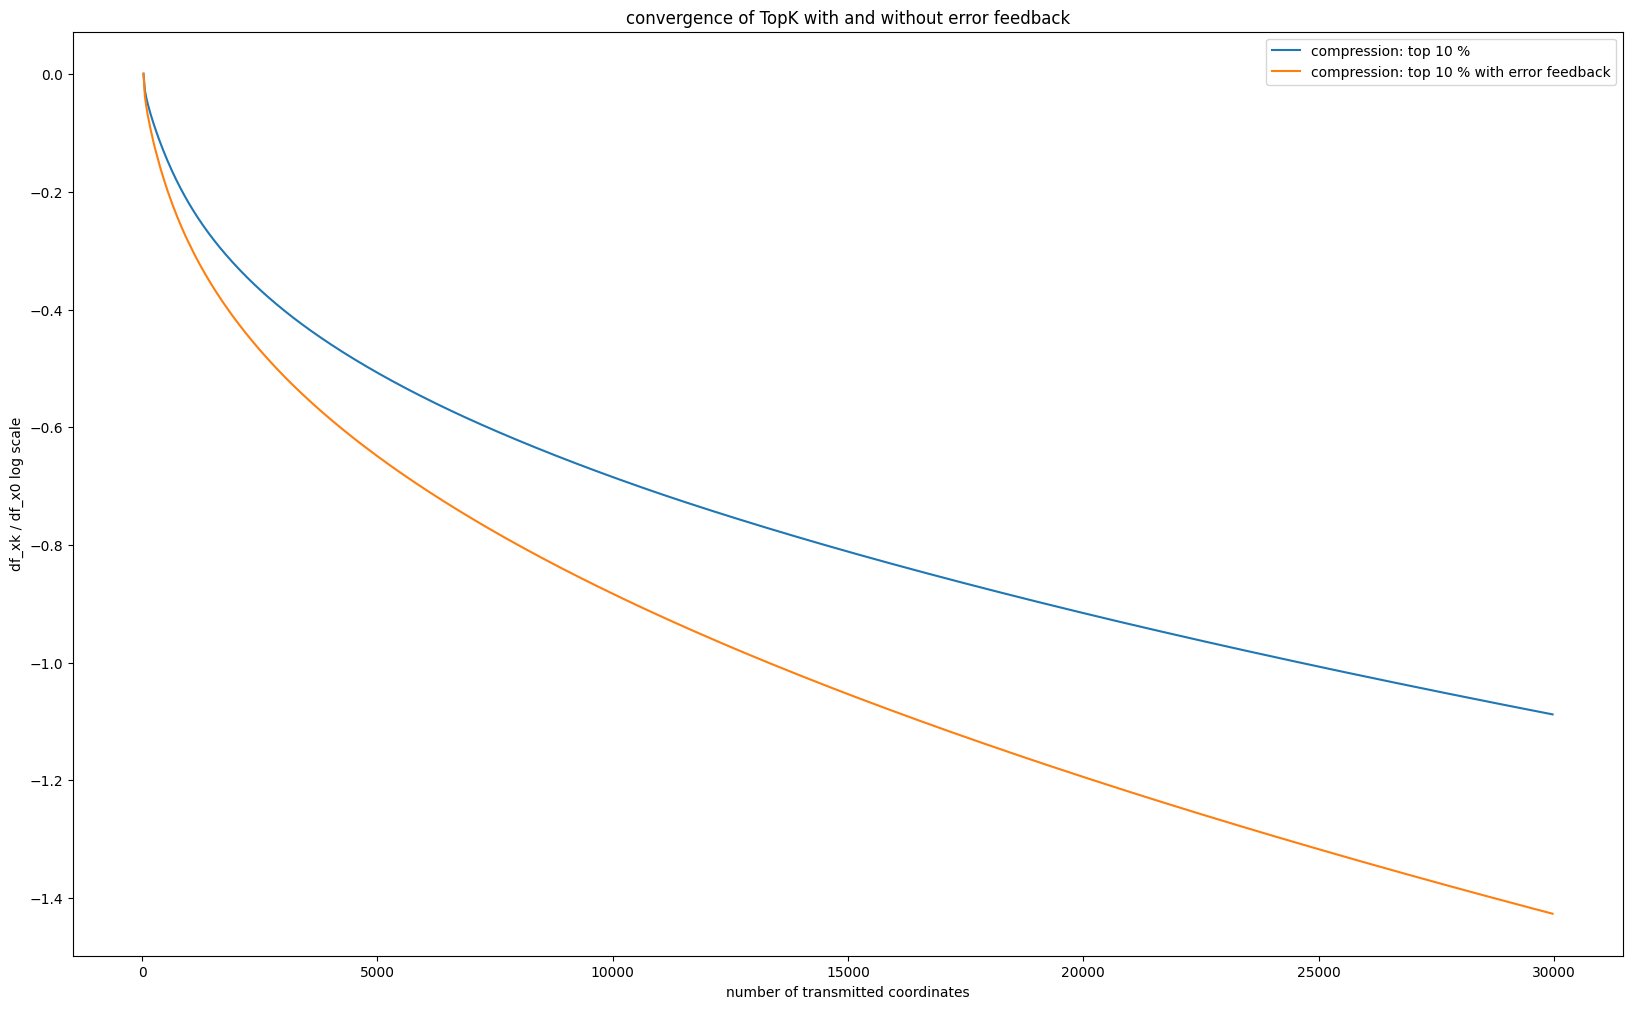

In [183]:
plt.figure(figsize=FIGURE_SIZE)
# the regular distributed regime
x_0 = set_up()
top10_points, top10_criterions = regular_distributed_gd(
                            data=X_train,
                            labels=y_train,
                            devices_data=DEVICES_DATA,
                            devices_labels=DEVICES_LABELS,
                            function=p2_distributed_function,
                            grad_function=p2_distributed_grad,
                            compression_function=TOP_10_COMPRESSION,
                            x_0=x_0,
                            gamma_k=lambda _ : TOP10_STEP_SIZE,
                            mode=normalized_criterion, 
                            return_history=True,
                            )   

top10_accuracies = [calculate_accuracy(predictions=predict(w, X_test), labels=y_test) for w in top10_points] 

top10_criterions = [np.log10(c) for c in top10_criterions]

plot_iterations(criterions=top10_criterions, 
                x_label='iteration', 
                y_label=f'{normalized_criterion} log scale', 
                xs=[(i + 1) * 30 for i in range(len(top10_criterions))],
                plot_label=f'compression: top 10 % ',
                show=False)

# the distributed regime with error feedback
ef_points, ef_points, ef_criterions = distributed_gradient_error_feedback(
                            data=X_train,
                            labels=y_train,
                            devices_data=DEVICES_DATA,
                            devices_labels=DEVICES_LABELS,
                            function=p2_distributed_function,
                            grad_function=p2_distributed_grad,
                            compression_function=TOP_10_COMPRESSION,
                            x_0=x_0,
                            gamma_k=lambda _ : ERROR_FEEDBACK_BEST_SIZE,
                            mode=normalized_criterion, 
                            return_history=True,
                            )   

ef_criterions = [np.log10(c) for c in ef_criterions]

ef_accuracies = [calculate_accuracy(predictions=predict(w, X_test), labels=y_test) for w in ef_points] 
plot_iterations(criterions=ef_criterions, 
                x_label='number of transmitted coordinates', 
                y_label=f'{normalized_criterion} log scale', 
                xs=[(i + 1) * 30 for i in range(len(ef_criterions))],
                plot_label=f'compression: top 10 % with error feedback',
                show=False)


plt.legend()
plt.title(f"convergence of TopK with and without error feedback")
plt.show()

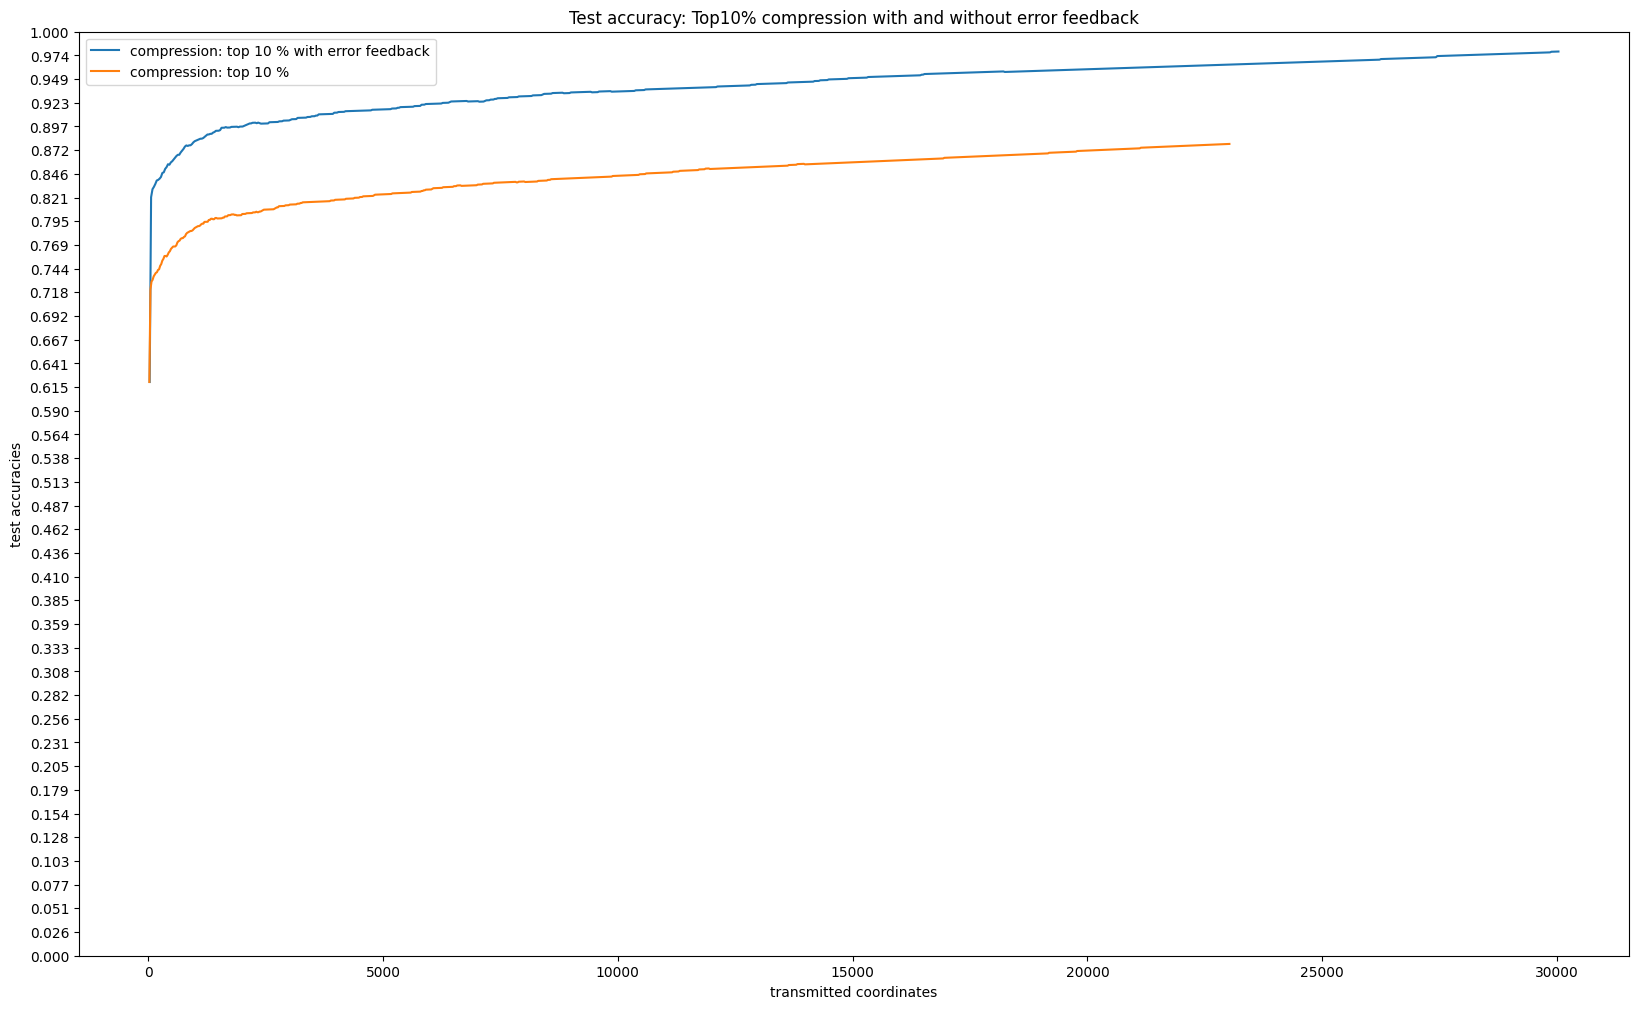

In [187]:
plt.figure(figsize=FIGURE_SIZE)

plot_iterations(criterions=ef_accuracies,
                x_label='transmitted coordinates', 
                y_label=f'test accuracies', 
                xs=[(i + 1) * 30 for i in range(len(ef_accuracies))],
                plot_label=f'compression: top 10 % with error feedback',
                show=False)

plot_iterations(top10_accuracies,
                xs=[(i + 1) * trans_coordinates for i in range(len(top10_accuracies))],
                x_label='transmitted coordinates', 
                y_label=f'test accuracies', 
                plot_label=f'compression: top 10 %',
                show=False)

plt.legend()
plt.yticks(np.linspace(0, 1, 40))
plt.title("Test accuracy: Top10% compression with and without error feedback")
plt.show()

1. We can see that the TopK Compression method did not converge too well (The paper gives proves that an unbiased compression method does not gurantee convergences in Distributed setting). However, this issue is fixed by adding the error feedback mechansim. This conclusion can be seen from both the improvement in accuracy and convergence criterion.

# Problem 3. (15 points)

This part of the assignment is related to __distributed with local steps__ methods.

As in the previous problem we simulate the distributed enviroment with $s = 10$. 

Implement simple Local GD/FedAvg method (Algorithm 1 of [paper](https://arxiv.org/pdf/1909.04746.pdf)), where you can choose the number of local steps $H$ as a parameter. 

Vary the number of local steps: $H = 1, 5, 10, 20$.

Take hyperparameters of the method according to the theory (see the corresponding paper). 

Write these parameters. 

Draw the comparison plots for different $H$: 

1) value of convergence criterion versus number of communications, 
2) accuracy of predictions versus number of communications. 

Make a conclusion.

### Hyperparameters
Let's prove that our data is homogeneous / identical by analytically bounding the difference of gradients: 

\begin{align}
\| \nabla f_i(w) - \nabla f_j(w) \| &= \| \nabla f_i(w) - \lambda \cdot w - (\nabla f_j(w) - \lambda \cdot w) \| \\
& \leq \| \nabla f_i(w) - \lambda \cdot w \| + \| (\nabla f_j(w) - \lambda \cdot w) \| \\
& = \| \frac{1}{b} \sum_{k=1}^b \frac{-y_{(i-1)b + k} x_{(i-1)b + k}}{1 + \exp(y_{(i-1)b + k} w^Tx_{(-1)b + k})}. \| + \| \frac{1}{b} \sum_{k=1}^b \frac{-y_{(j-1)b + k} x_{(j-1)b + k}}{1 + \exp(y_{(j-1)b + k} w^Tx_{(j-1)b + k})}. \| \\
& \leq \max_{k = 1, 2, ... b} { \|x_{(i-1)b + k}\|} + \max_{k = 1, 2, ... b} { \|x_{(j-1)b + k}\|} \\
\| \nabla f_i(w) - \nabla f_j(w) \| &\leq 2 \cdot \max_{x \in data} \|x\|
\end{align}

This enables us to choose the hyperparameters for the homogenous / identical data: 

* step size: $\frac{1}{4L}$

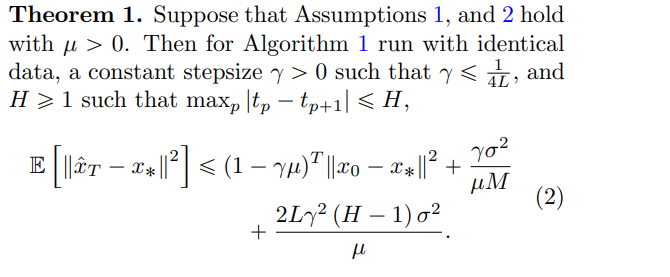

### Local Gradient Descent

In [126]:
class LocalGradientDescentDevice:
    def __init__(self, 
                 gradient_function: callable, 
                 data: np.ndarray,
                 labels: np.ndarray,
                 num_local_steps: int
                 ) -> None:
        self.data = data
        self.labels = labels
        self.gradient_function = gradient_function 
        self.H = num_local_steps

    def local_grad(self, x_current: np.ndarray, step_size: float) -> np.ndarray:  
        x = x_current.copy()
        for _ in range(self.H):
            grad = self.gradient_function(self.data,self.labels,x)
            x = x - step_size * grad
        return x

In [127]:
def local_GD(
    num_local_steps:int,
    data: np.ndarray,
    labels: np.ndarray,
    devices_data: Sequence[np.ndarray],
    devices_labels: Sequence[np.ndarray],
    function: callable,
    grad_function: callable,
    x_0: np.ndarray,
    x_sol: np.ndarray=None,
    K: int = 10 ** 3,
    eps: float = 10 ** -5, 
    mode: str = normalized_criterion,
    gamma_k: callable = None,                      
    return_history: bool = False
    ) -> Union[List[np.ndarray], np.ndarray]:

    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

    # make sure the number of local_steps is at least 1
    num_local_steps = max(1, num_local_steps)

    # define the local devices
    devices = [LocalGradientDescentDevice(gradient_function=grad_function,
                                          data=d_data, 
                                          labels=d_labels,
                                          num_local_steps=num_local_steps
                                        ) for d_data, d_labels in zip(devices_data, devices_labels)]

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0
    x_history = [x_current]
    criterion_history = []

    for k in tqdm(range(math.ceil(K / num_local_steps))):
        x_previous = x_current.copy()

        gamma = gamma_k(k)

        x_current = np.mean([d.local_grad(x_current=x_current, step_size=gamma) for d in devices], axis=0).reshape(-1, 1)
        
        func_args = {"X": data, "y": labels, 'w': x_current}

        if mode == f_diff:
            diff = f_difference(function(**func_args), function(**func_args))
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            diff = norm(grad_function(**func_args), ord=2) / norm(grad_function(**{"X": data, 'y': labels, 'w': x_0}), ord=2)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
            
        if diff <= eps: 
            break

        assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    return  (x_history, criterion_history) if return_history else x_history[-1]

100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s]


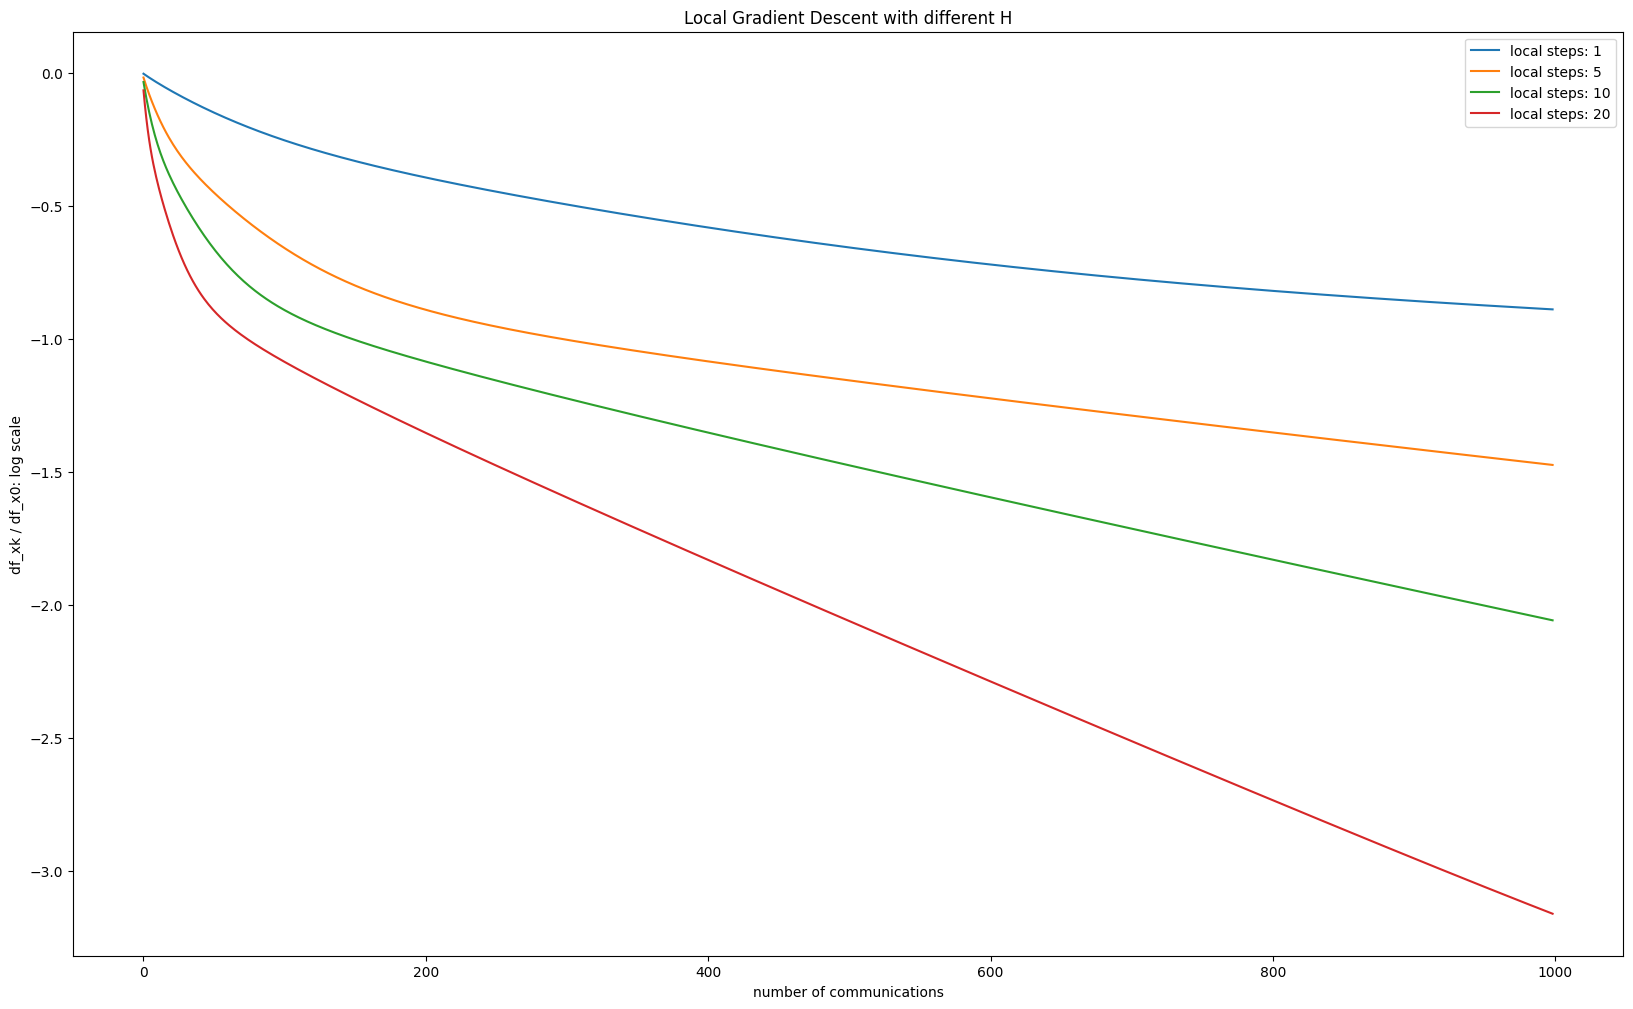

In [133]:
plt.figure(figsize=FIGURE_SIZE)
local_steps = [1, 5, 10, 20]
gamma_k = lambda _ : 1 / (4 * L_TILED)
accuracies = []

for l in local_steps:
    # create the function
    x_0 = set_up()
    x_points, criterions = local_GD(num_local_steps=l,
                                data=X_train,
                                labels=y_train,
                                devices_data=DEVICES_DATA,
                                devices_labels=DEVICES_LABELS,
                                function=p2_distributed_function,
                                grad_function=p2_distributed_grad,
                                x_0=x_0,
                                gamma_k=gamma_k,
                                mode=normalized_criterion, 
                                return_history=True,
                                K = 10 ** 3 * l
                                )   

    criterions = [np.log10(c) for c in criterions]
    plot_iterations(criterions=criterions, 
                    x_label='number of communications', 
                    y_label=f'{normalized_criterion}: log scale', 
                    plot_label=f'local steps: {l}',
                    show=False)

    accs = [calculate_accuracy(predictions=predict(x, X_test), labels=y_test) for x in x_points]
    accuracies.append(accs)

plt.legend()
plt.title(f"Local Gradient Descent with different H")
plt.show()     


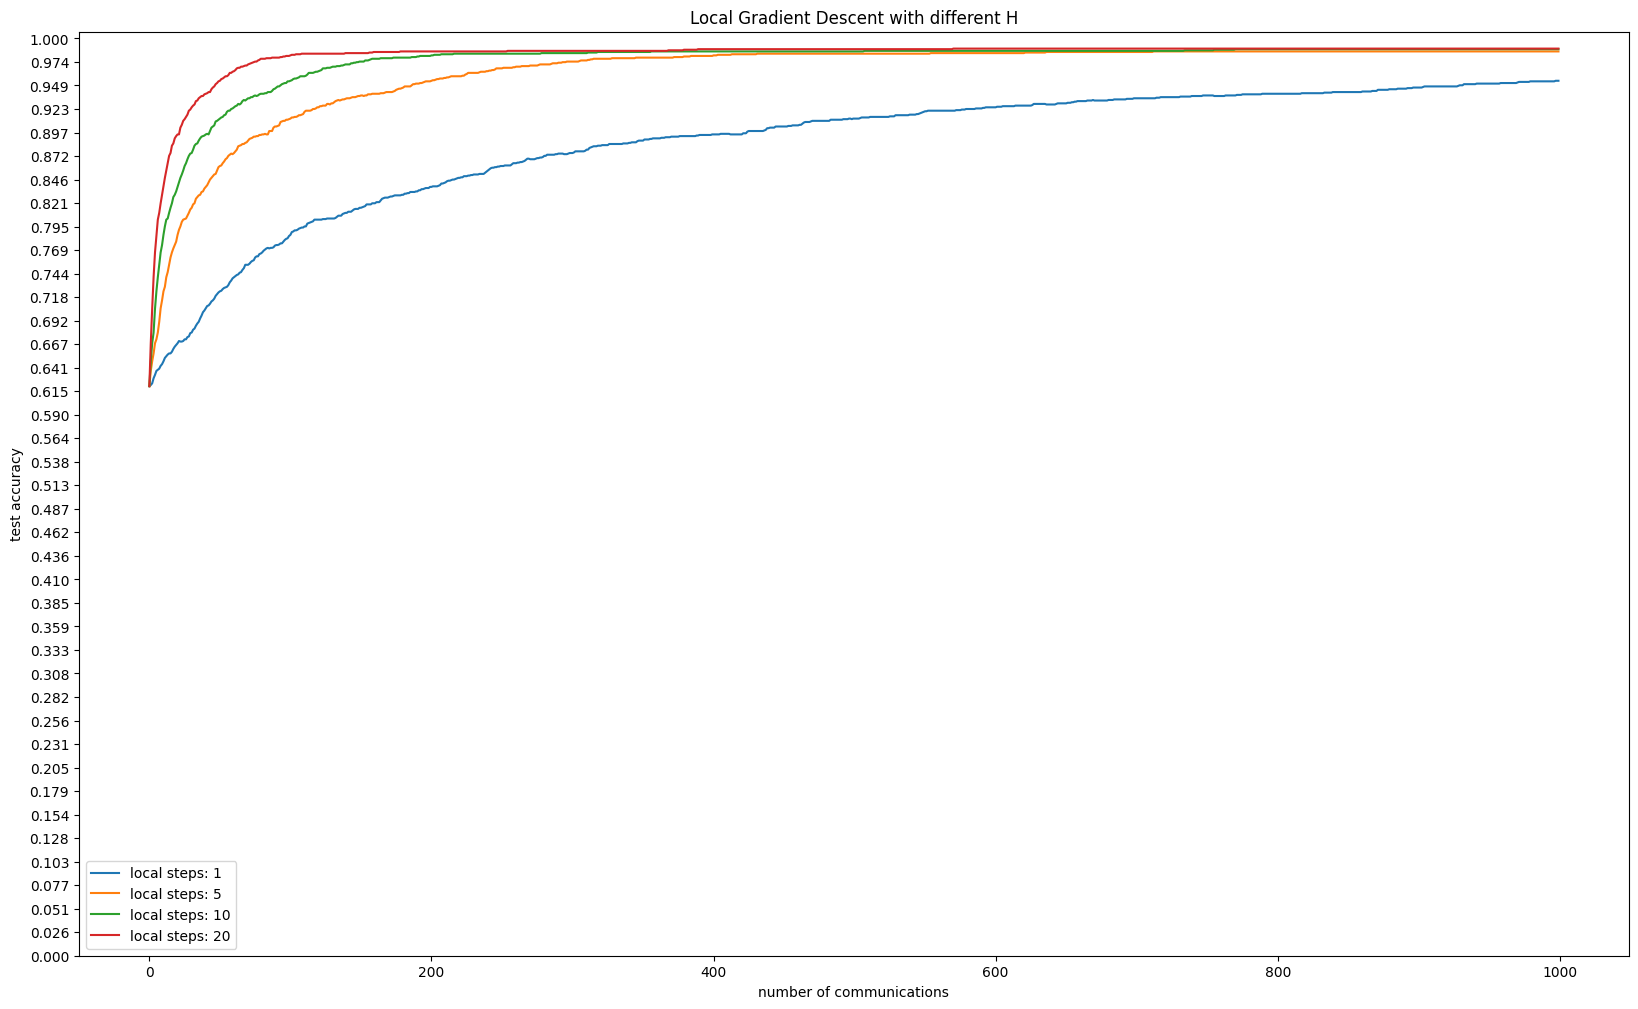

In [135]:
plt.figure(figsize=FIGURE_SIZE)
for acc, l in zip(accuracies, local_steps):
    plot_iterations(criterions=acc, 
                    x_label='number of communications', 
                    y_label=f'test accuracy', 
                    plot_label=f'local steps: {l}',
                    show=False)

plt.yticks(np.linspace(0, 1, num=40))
plt.legend()
plt.title(f"Local Gradient Descent with different H")
plt.show()     

### Conclusion
We can see that the results of the experiments above align with the theoretical expectations: 

The  accuracy and convergence are inversely proportional to the number of local steps. This is to be expected since the data is homogenous: minimizing the local objectives will end up minimizing the local objective as well. 
